# Real Estate Investment Analysis for Zillow Data

#Project Overview

In this project, we aim to assist Zillow real-estate investment firm in identifying the top 5 states for investment based on historical housing data from Zillow. The firm seeks to maximize returns by strategically investing in areas with high potential for property value appreciation over the next few years. Our analysis will leverage time series forecasting techniques to predict future property prices and recommend the most promising states for investment.

#Business Problem

Zillow investment firm faces the challenge of selecting the most lucrative states for investment amidst fluctuating real estate markets. By utilizing historical data and advanced analytics, our goal is to provide actionable insights taking into account:

Profit potential: Expected price appreciation and potential rental income.

Risk: Volatility and stability of the price forecasts.

Time horizon: Appropriate time frame for the investment (e.g., short-term, long-term).

#Stakeholder

The primary stakeholder for this project is the investment committee of the Zillow real-estate investment firm. They are interested in understanding the historical trends, seasonality, and predictive patterns in housing market data to identify areas that offer the highest potential for property value growth and rental income.

#Objectives

Data Collection: Gather and preprocess historical housing data from Zillow, focusing on key metrics such as median home prices, rental yields, and historical price trends.

Exploratory Data Analysis (EDA): Explore the dataset to identify trends, seasonality, and correlations between variables. Visualize key metrics to gain insights into historical market behavior.

Time Series Modeling: Apply time series forecasting techniques (e.g., ARIMA) to model and predict future property prices for selected states.

Ranking and Recommendation: Develop a ranking system based on forecasted price appreciation, rental yields, and risk metrics to recommend the top 5 states for investment.

#Methodology

###Data Loading and Filtering:

Load the Zillow dataset and filter it for the states we are interested in.

###Data Preprocessing:

Convert the column names representing dates into datetime objects.

###Exploratory Data Analysis (EDA) and Visualization:

Visualize the historical price trends for the selected states.
Reshape Data from Wide to Long Format:

Convert the data into a format suitable for time series modeling.

###ARIMA Modeling:

Fit ARIMA models to forecast future housing prices for each selected zip code.

###Interpreting Results:

Evaluate the forecasts and provide a detailed recommendation.

Profit Potential: Consider both the forecasted increase in housing prices and the confidence intervals.

Risk Assessment: Evaluate the stability and trends in the historical data.

Time Horizon: Assess the appropriate investment duration based on the forecasts and market trends.

Conclusion
Summarize our findings and provide final thoughts on the investment opportunities in the selected states.


## Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

excel_file_path = "/content/zillow_data.csv"

df = pd.read_csv(excel_file_path)


df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Data Preprocessing

In [2]:
# Step 1: Handle missing values
# Check for missing values
missing_values = df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

Metro      1043
1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
           ... 
2014-02      56
2014-03      56
2014-04      56
2014-05      56
2014-06      56
Length: 220, dtype: int64

In [3]:
# Define a threshold for dropping columns
threshold = 0.2 * len(df)

# Drop columns with more than 20% missing values
df_dropped = df.dropna(thresh=threshold, axis=1)

# Forward fill the remaining missing values
df_filled = df_dropped.fillna(method='ffill').fillna(method='bfill')

# Check if there are any remaining missing values
remaining_missing_values = df_filled.isnull().sum()
remaining_missing_values[remaining_missing_values > 0]
remaining_missing_values


RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [4]:
df_filled.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## EDA and Visualization

### Univariate analysis

In [5]:
# Melt the DataFrame to long format using date columns
df_melted = pd.melt(df_filled, value_vars=df_filled.columns, var_name='Date', value_name='Price')
# Drop rows where 'Price' is NaN
df_melted = df_melted.dropna(subset=['Price'])

# Convert 'Price' to numeric if needed
df_melted['Price'] = pd.to_numeric(df_melted['Price'], errors='coerce')

# Convert 'Date' to datetime format
df_melted['Date'] = pd.to_datetime(df_melted['Date'], format='%Y-%m', errors='coerce')

# Remove rows where 'Date' is NaT (not a valid date)
df_melted = df_melted.dropna(subset=['Date'])

# Calculate average price for each date
avg_prices = df_melted.groupby('Date')['Price'].mean()

df_melted.head()

,Date,Price
103061,1996-04-01,334200.0
103062,1996-04-01,235700.0
103063,1996-04-01,210400.0
103064,1996-04-01,498100.0
103065,1996-04-01,77300.0


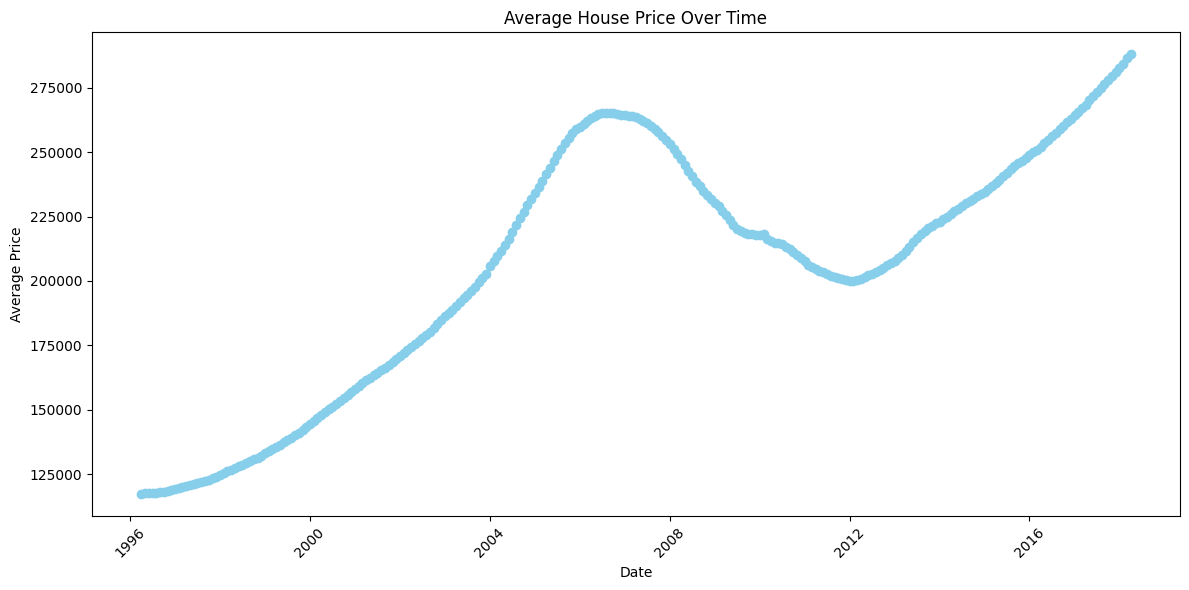

In [6]:
# Plot line graph
plt.figure(figsize=(12, 6))
plt.plot(avg_prices.index, avg_prices.values, marker='o', linestyle='-', color='skyblue')
plt.title('Average House Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


Shows a steady upward trend with a decline between 2008 and 2012 as a result of the financial crisis caused by the bursting of the housing market bubble.

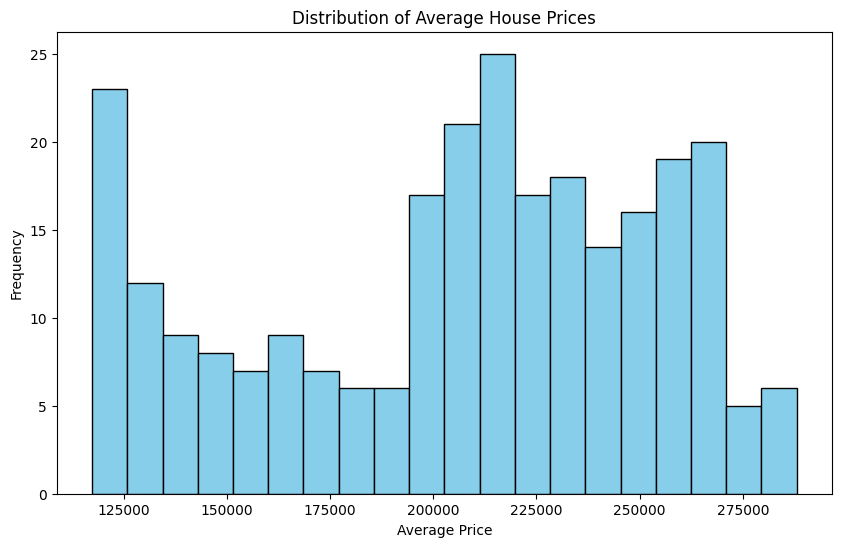

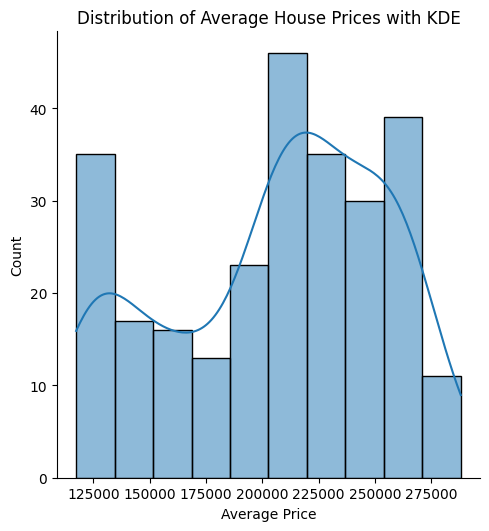

In [7]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(avg_prices.values, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Average House Prices')
plt.xlabel('Average Price')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# kernel density plot, use Seaborn
sns.displot(avg_prices.values, kde=True)
plt.title('Distribution of Average House Prices with KDE')
plt.xlabel('Average Price')
plt.show()

The average house prices are not evenly distributed. There are more houses in the middle price range, and fewer houses that are very expensive or very inexpensive.




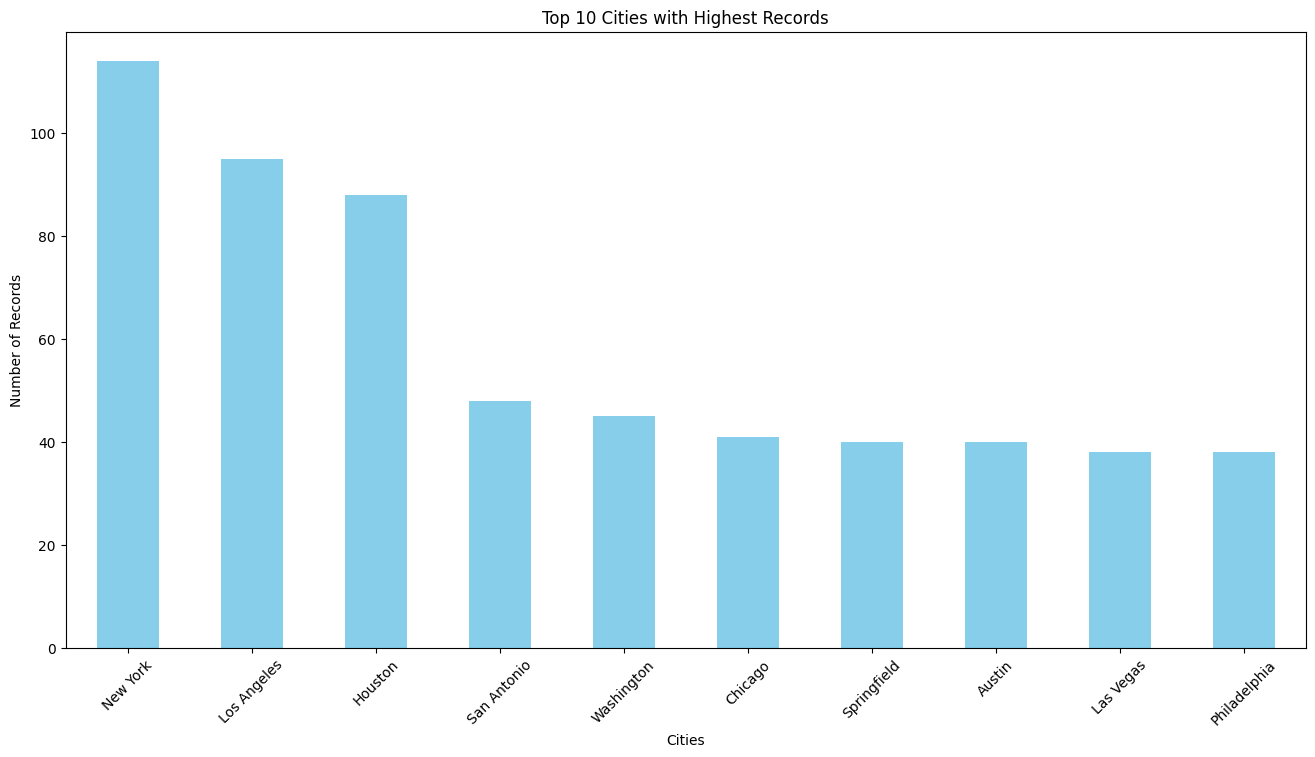

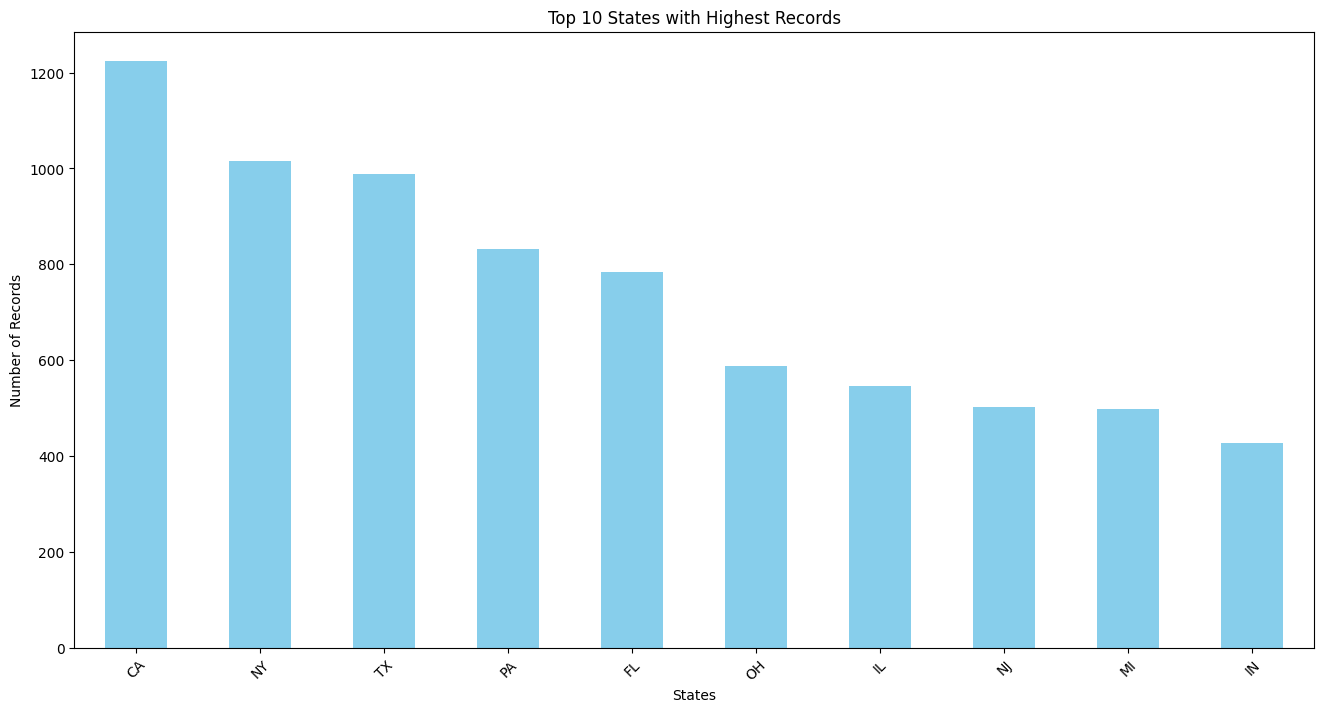

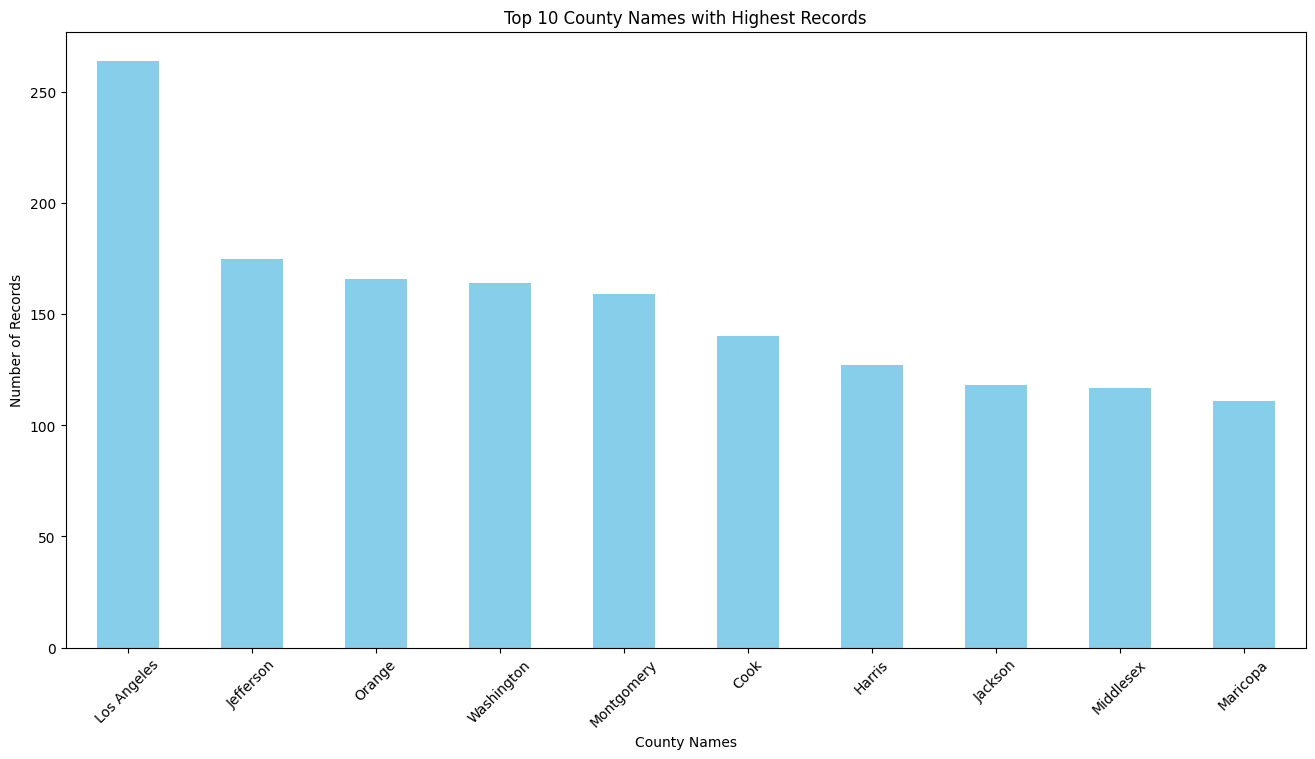

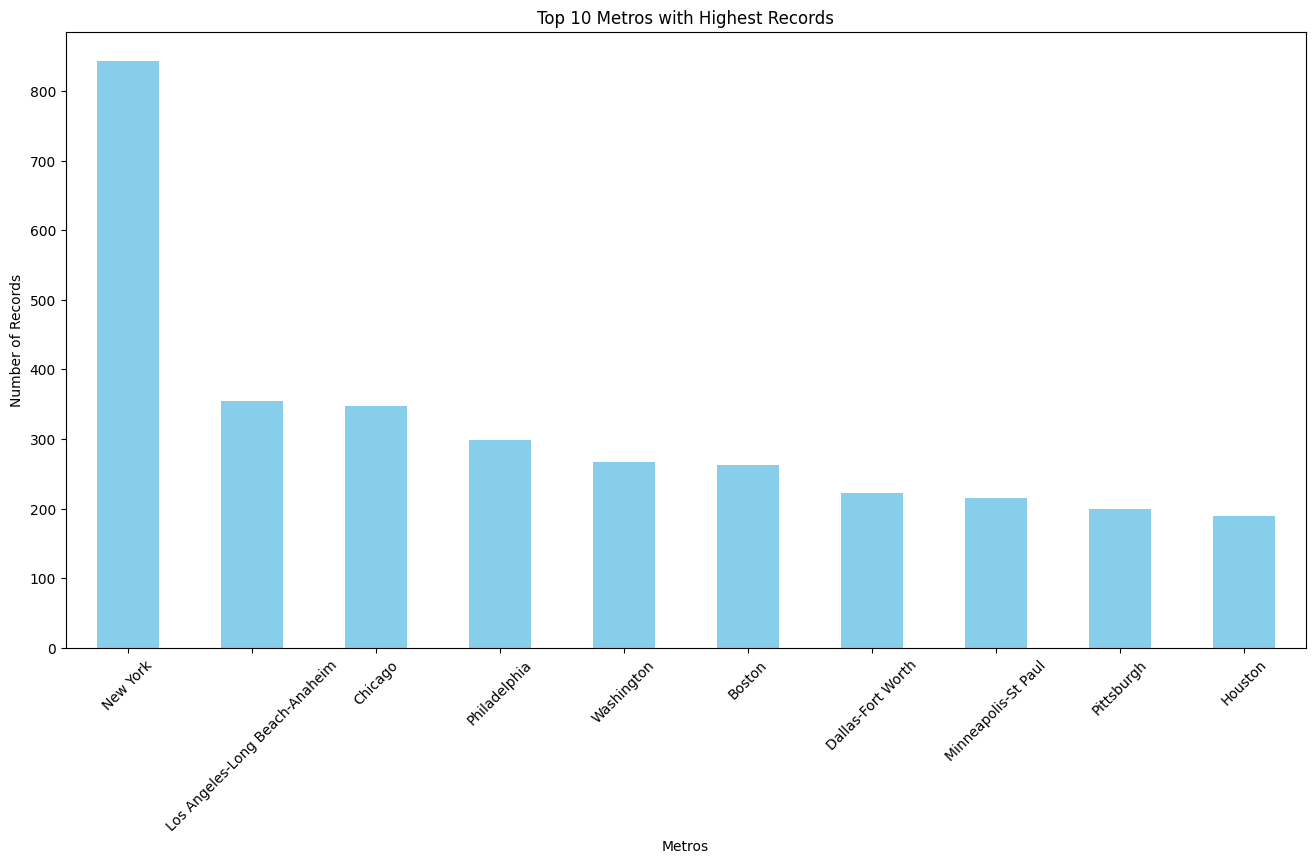

In [8]:
def plot_top_10(df, column_name, title):
    counts = df[column_name].value_counts().head(10)
    plt.figure(figsize=(16, 8))
    counts.plot(kind='bar', color='skyblue')
    plt.title(f'Top 10 {title} with Highest Records')
    plt.xlabel(title)
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45)
    plt.show()

# Plot for City
plot_top_10(df_filled, 'City', 'Cities')

# Plot for State
plot_top_10(df_filled, 'State', 'States')

# Plot for CountyName
plot_top_10(df_filled, 'CountyName', 'County Names')

# Plot for Metro
plot_top_10(df_filled, 'Metro', 'Metros')

New York, California and the cities/counties within them generally have a high region count. Possibly indicating a high population.

### Bivariate analysis

In [9]:
# Identify date columns
date_columns = [col for col in df_filled.columns if '-' in col and col[:4].isdigit()]

# Melt the DataFrame to long format using date columns
df_melted = pd.melt(df_filled, id_vars=['City', 'State', 'CountyName', 'Metro'],
                    value_vars=date_columns, var_name='Date', value_name='Price')

# Drop rows where 'Price' is NaN
df_melted = df_melted.dropna(subset=['Price'])

# Convert 'Price' to numeric if needed
df_melted['Price'] = pd.to_numeric(df_melted['Price'], errors='coerce')

# Convert 'Date' to datetime format
df_melted['Date'] = pd.to_datetime(df_melted['Date'], format='%Y-%m')

In [10]:
df_melted.head()

,City,State,CountyName,Metro,Date,Price
0,Chicago,IL,Cook,Chicago,1996-04-01,334200.0
1,McKinney,TX,Collin,Dallas-Fort Worth,1996-04-01,235700.0
2,Katy,TX,Harris,Houston,1996-04-01,210400.0
3,Chicago,IL,Cook,Chicago,1996-04-01,498100.0
4,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [11]:
# Create a function to plot line graphs for average prices in different columns
def plot_top_5_prices(df, group_by_column, title):
    # Calculate average prices for each group and date
    avg_prices = df.groupby([group_by_column, 'Date'])['Price'].mean().reset_index()

    # Find top 5 groups by average price over all dates
    top_5_groups = avg_prices.groupby(group_by_column)['Price'].mean().sort_values(ascending=False).head(5).index

    # Filter to only include top 5 groups
    top_5_avg_prices = avg_prices[avg_prices[group_by_column].isin(top_5_groups)]

    # Plot line graph
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    for group in top_5_groups:
        group_data = top_5_avg_prices[top_5_avg_prices[group_by_column] == group]
        plt.plot(group_data['Date'], group_data['Price'], label=group)

    plt.title(f'Top 5 {title} by Average House Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.legend(title=title)
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.tight_layout()  # Ensures tight layout to prevent clipping
    plt.show()



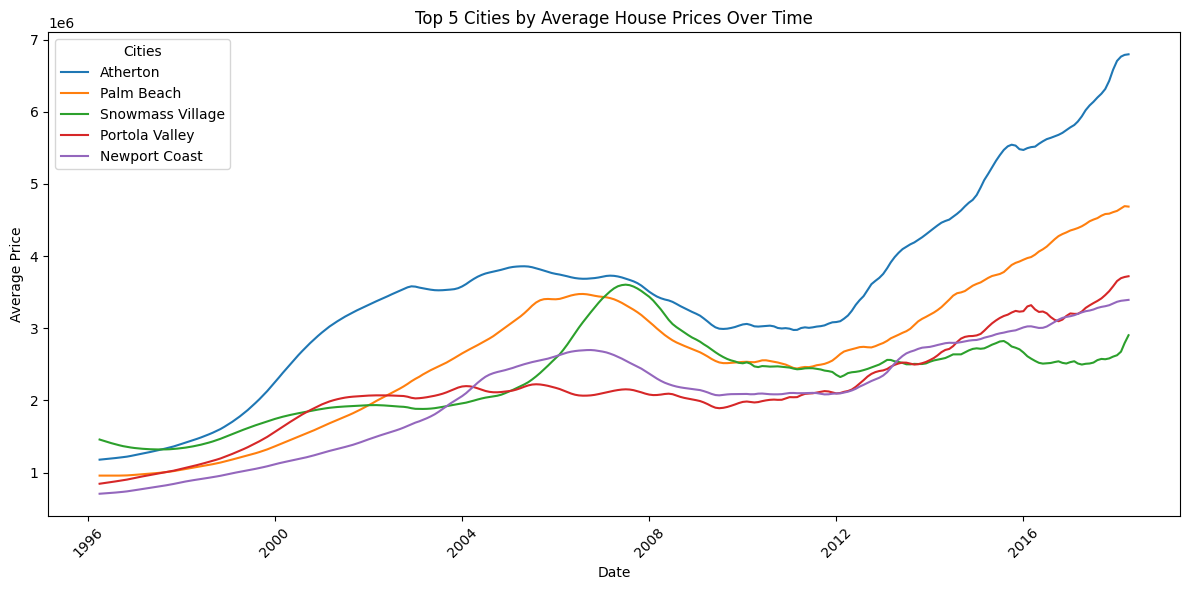

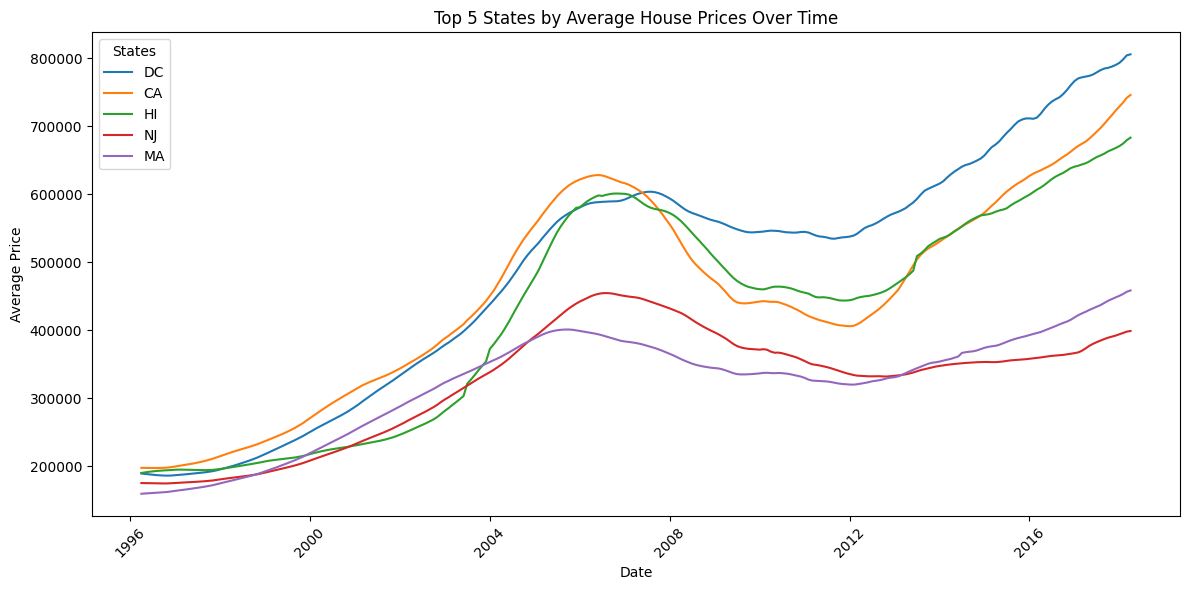

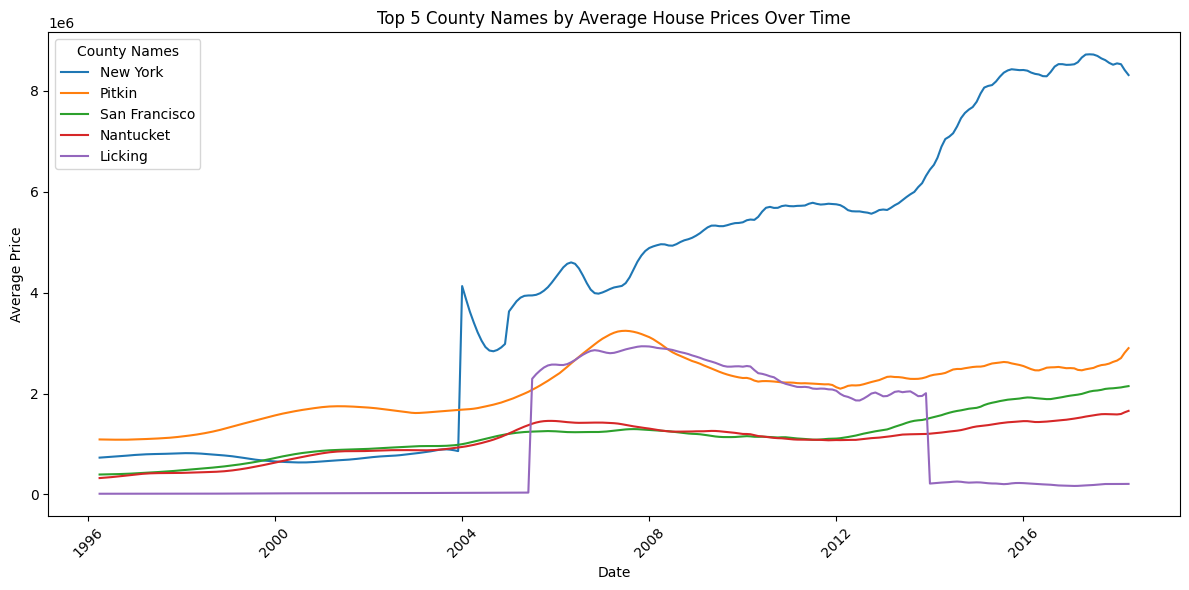

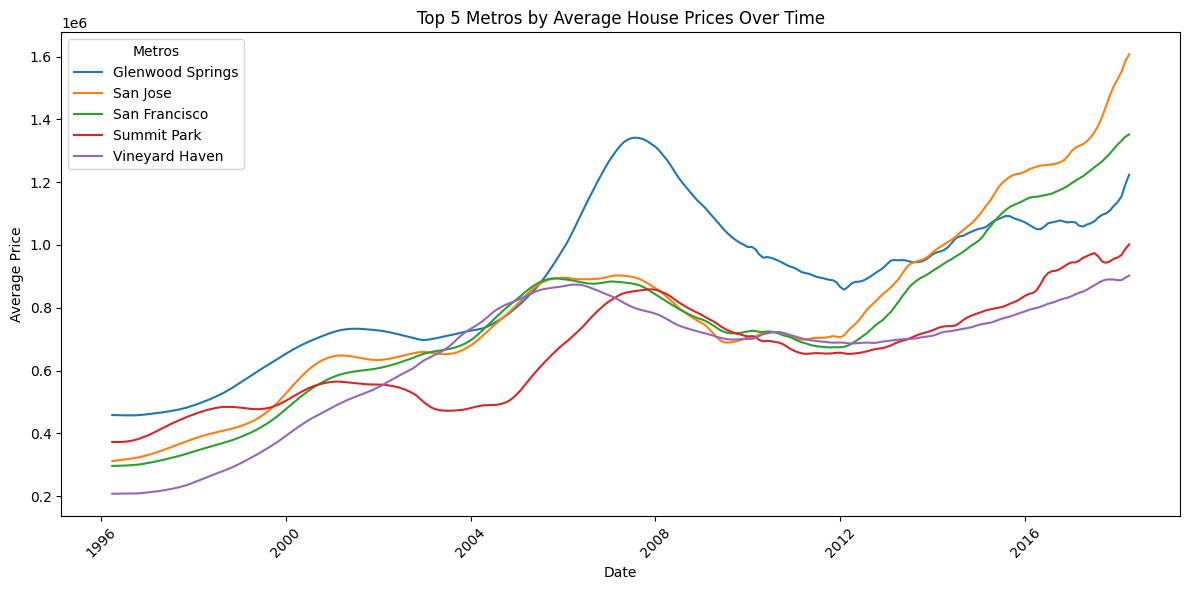

In [12]:
# Plot for City
plot_top_5_prices(df_melted, 'City', 'Cities')

# Plot for State
plot_top_5_prices(df_melted, 'State', 'States')

# Plot for CountyName
plot_top_5_prices(df_melted, 'CountyName', 'County Names')

# Plot for Metro
plot_top_5_prices(df_melted, 'Metro', 'Metros')

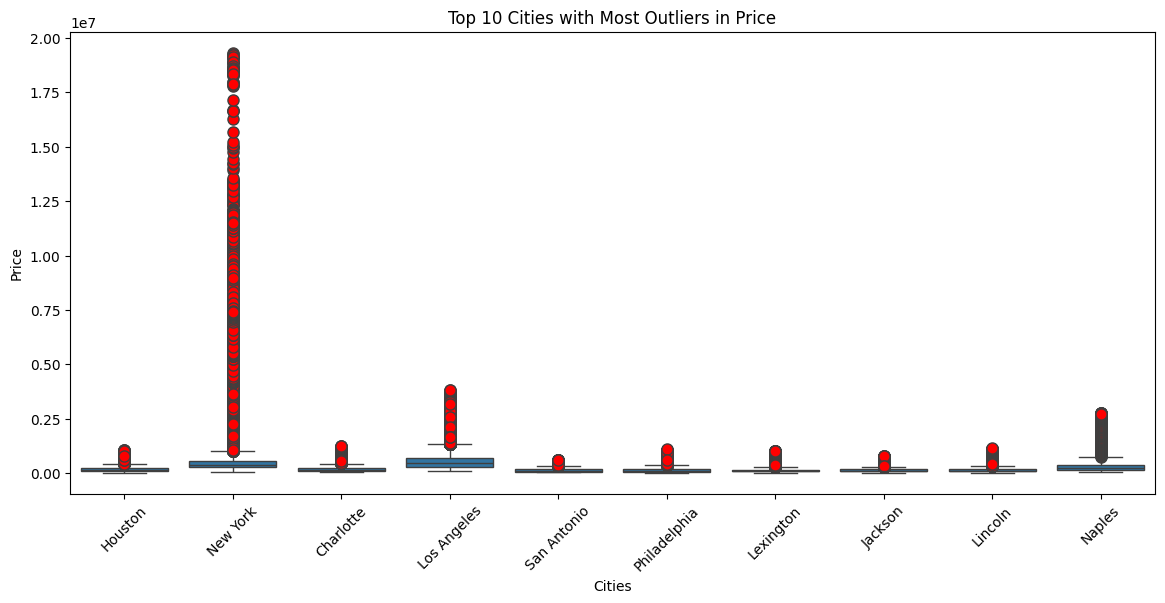

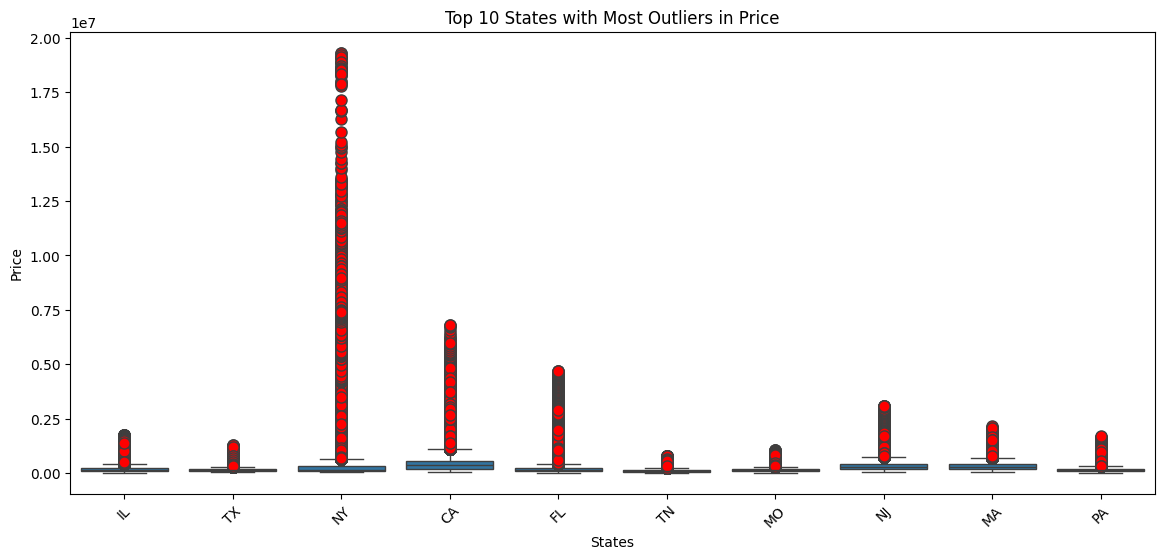

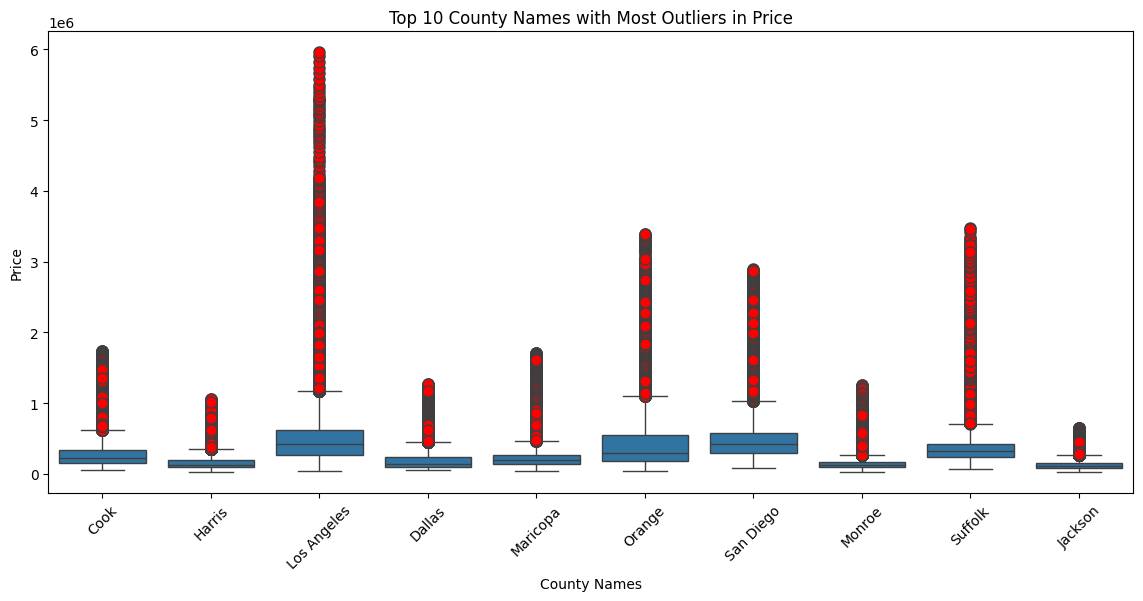

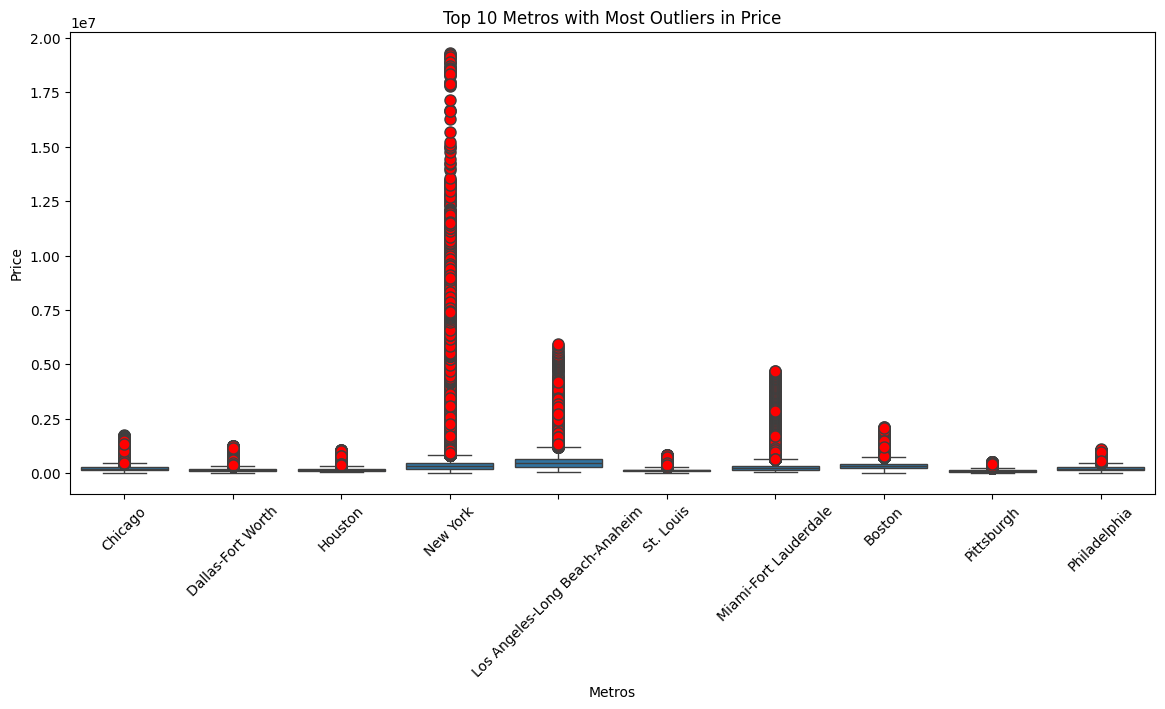

In [13]:
def plot_top_10_outliers(df, group_by_column, value_column, title):
    """
    Plots boxplots for the top 10 groups with the most outliers in the given value column.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        group_by_column (str): The column to group the data by.
        value_column (str): The column containing the values to plot.
        title (str): The title of the plot.
    """

    # Calculate the number of outliers for each group
    outlier_counts = df.groupby(group_by_column)[value_column].apply(lambda x: (np.abs(x - x.mean()) > 4 * x.std()).sum())

    # Get the top 10 groups with the most outliers
    top_10_groups = outlier_counts.sort_values(ascending=False).head(10).index

    # Filter the DataFrame to include only the top 10 groups
    df_filtered = df[df[group_by_column].isin(top_10_groups)]

    # Plot the boxplots
    plt.figure(figsize=(14, 6))
    # Removed the unsupported 'show_fliers' argument and used 'flierprops' instead.
    # 'flierprops' allows for customization of outlier marker appearance.
    sns.boxplot(x=group_by_column, y=value_column, data=df_filtered, flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8})
    plt.title(f'Top 10 {title} with Most Outliers in {value_column}')
    plt.xlabel(title)
    plt.ylabel(value_column)
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
plot_top_10_outliers(df_melted, 'City', 'Price', 'Cities')
plot_top_10_outliers(df_melted, 'State', 'Price', 'States')
plot_top_10_outliers(df_melted, 'CountyName', 'Price', 'County Names')
plot_top_10_outliers(df_melted, 'Metro', 'Price', 'Metros')

New York and California/Los Angeles feature again with a high number of outliers indicating high end properties in the areas and a rich population.

In [14]:
df_melted.columns

Index(['City', 'State', 'CountyName', 'Metro', 'Date', 'Price'], dtype='object')

In [15]:
def drop_numerical_outliers(df, z_thresh=3):
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Apply Z-score filter to the selected columns
    constrains = df[numeric_cols].apply(lambda x: np.abs(stats.zscore(x)) < z_thresh).all(axis=1)

    # Drop the rows that do not satisfy the constraints
    df.drop(df.index[~constrains], inplace=True)
    return df

In [16]:
 df_no_outliers = drop_numerical_outliers(df_melted.copy())

In [17]:
df_no_outliers.head()

,City,State,CountyName,Metro,Date,Price
0,Chicago,IL,Cook,Chicago,1996-04-01,334200.0
1,McKinney,TX,Collin,Dallas-Fort Worth,1996-04-01,235700.0
2,Katy,TX,Harris,Houston,1996-04-01,210400.0
3,Chicago,IL,Cook,Chicago,1996-04-01,498100.0
4,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [18]:
print("Before dropping numerical outliers, length of the dataframe is: ", len(df_melted))
print("After dropping numerical outliers, length of the dataframe is: ", len(df_no_outliers))

Before dropping numerical outliers, length of the dataframe is:  3901595
After dropping numerical outliers, length of the dataframe is:  3854307


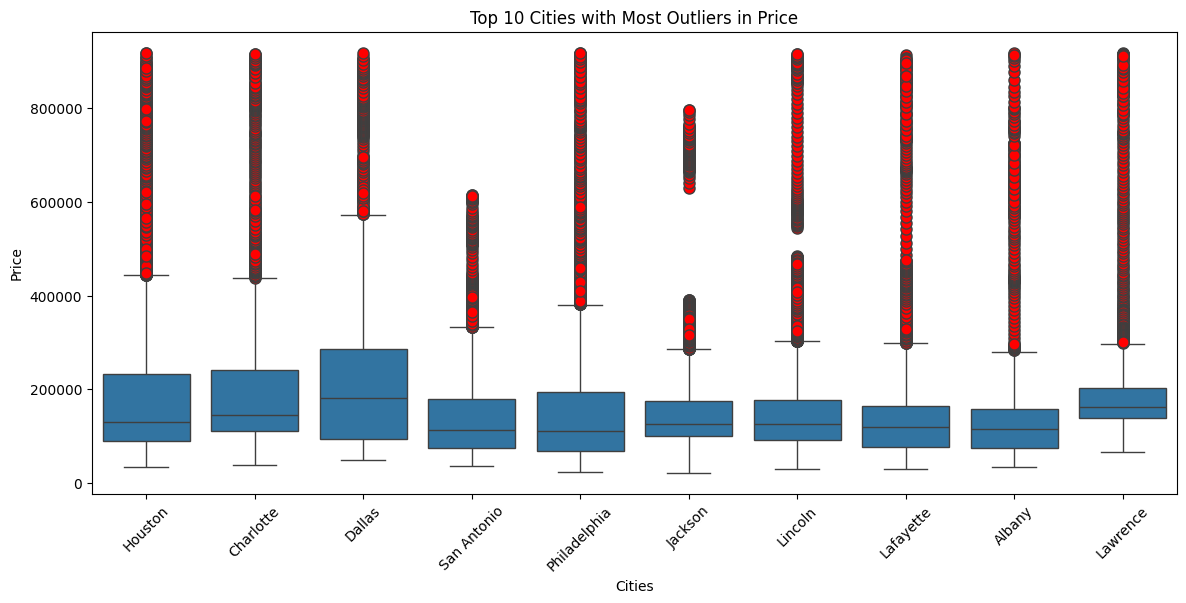

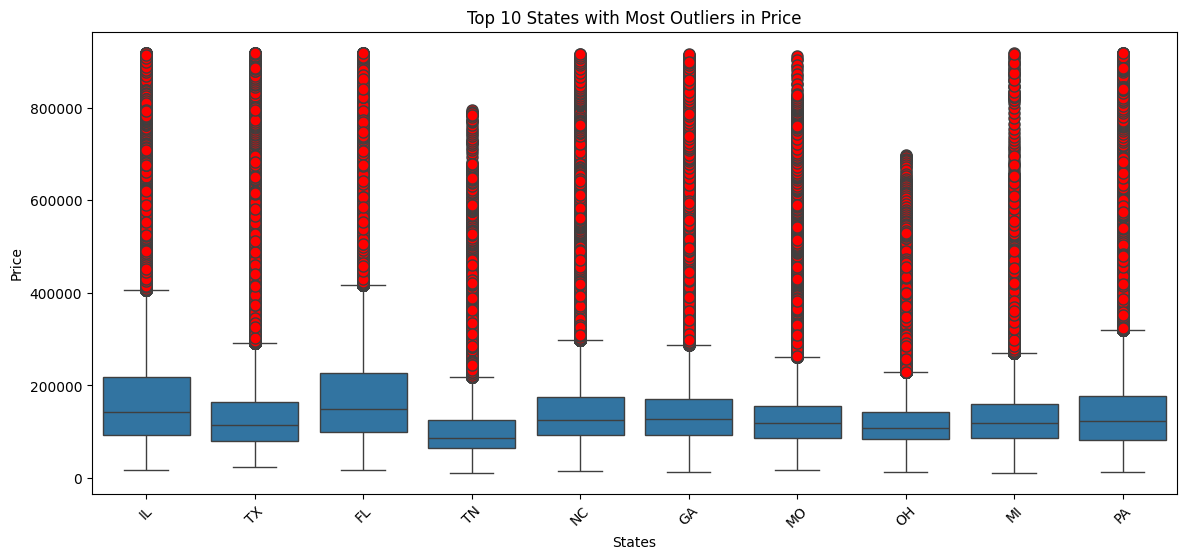

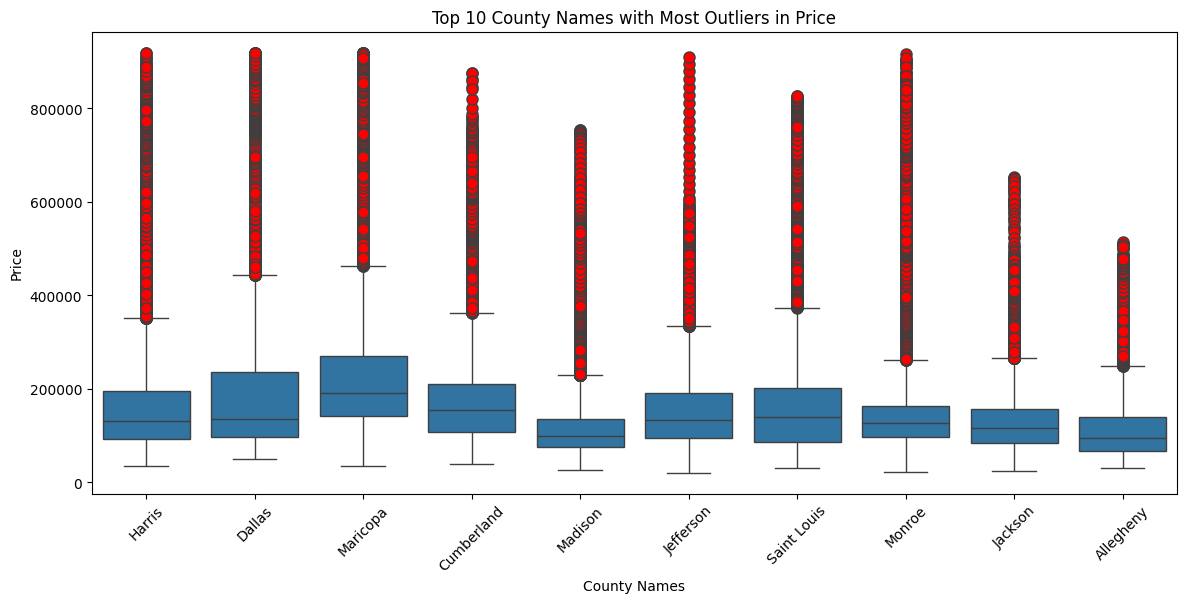

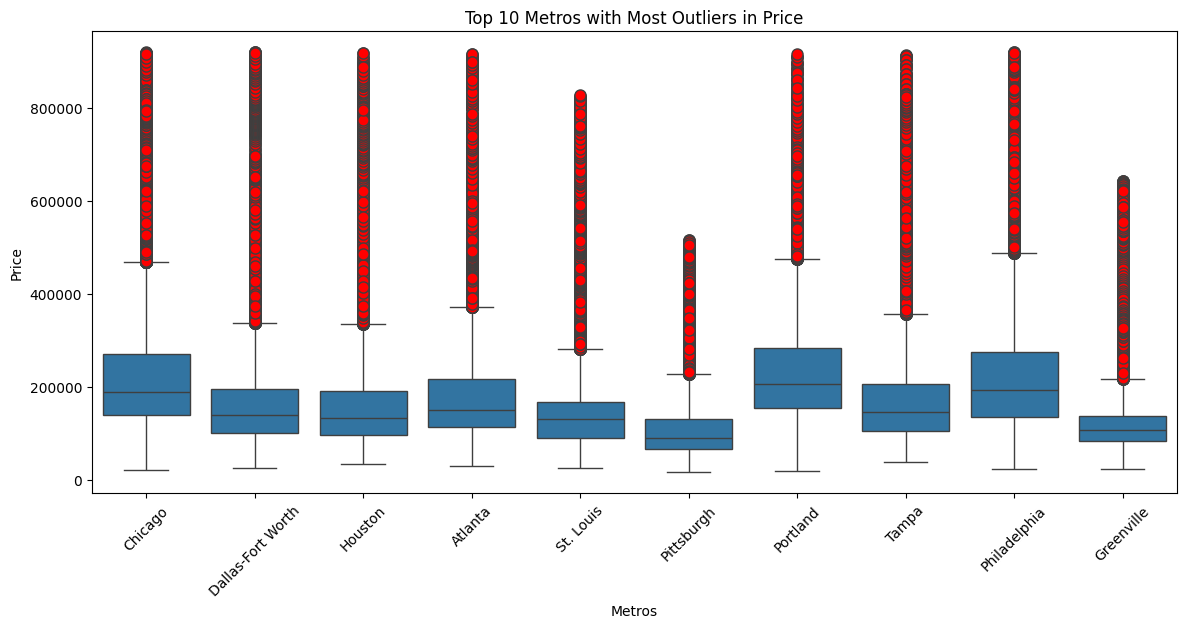

In [19]:
plot_top_10_outliers(df_no_outliers, 'City', 'Price', 'Cities')
plot_top_10_outliers(df_no_outliers, 'State', 'Price', 'States')
plot_top_10_outliers(df_no_outliers, 'CountyName', 'Price', 'County Names')
plot_top_10_outliers(df_no_outliers, 'Metro', 'Price', 'Metros')

The dataset contains fat tails showing a high number of extreme high prices and low prices that are hard to eliminate with a z-score threshold.

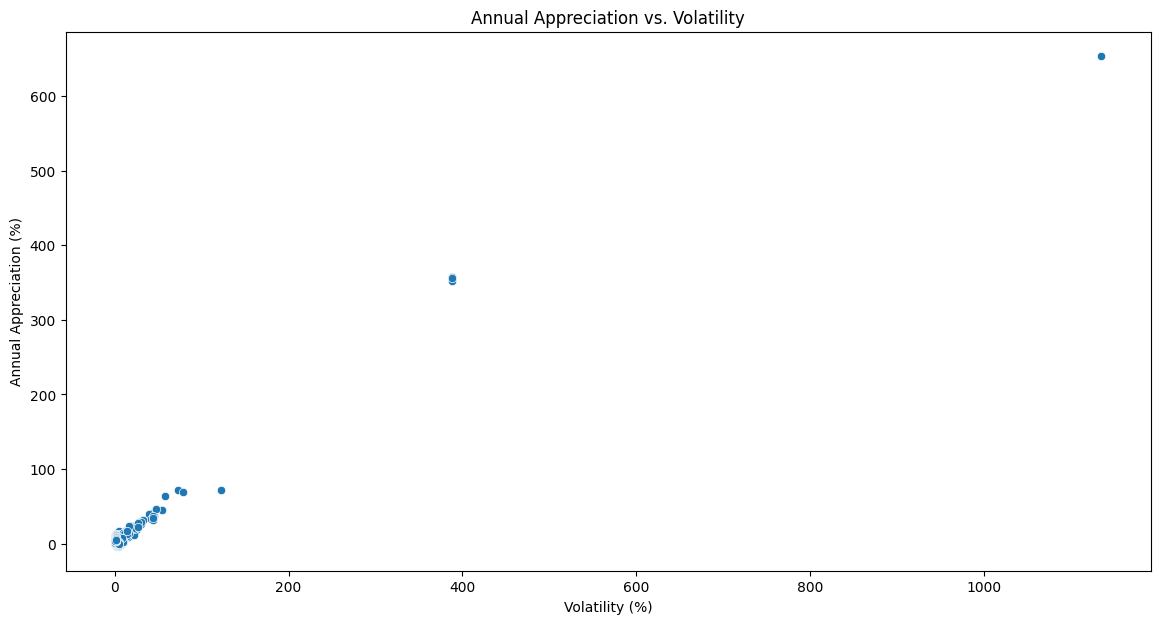

In [20]:
# Redefine price_data
price_data = df_filled.set_index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']).T.iloc[7:]

# Calculate annual appreciation rates
annual_appreciation_rates = price_data.pct_change(periods=12).mean() * 100

# Calculate the standard deviation of monthly price changes (volatility)
volatility = price_data.pct_change().std() * 100

# Combine into a single dataframe
metrics_df = pd.DataFrame({
    'RegionName': annual_appreciation_rates.index.get_level_values('RegionName'),
    'AnnualAppreciation': annual_appreciation_rates.values,
    'Volatility': volatility.values
})

# Bivariate plot: Annual appreciation vs. volatility
plt.figure(figsize=(14, 7))
sns.scatterplot(x='Volatility', y='AnnualAppreciation', data=metrics_df)
plt.xlabel('Volatility (%)')
plt.ylabel('Annual Appreciation (%)')
plt.title('Annual Appreciation vs. Volatility')
plt.show()


In [21]:
# Df without outliers
df_filled_no_outliers = drop_numerical_outliers(df_filled.copy())


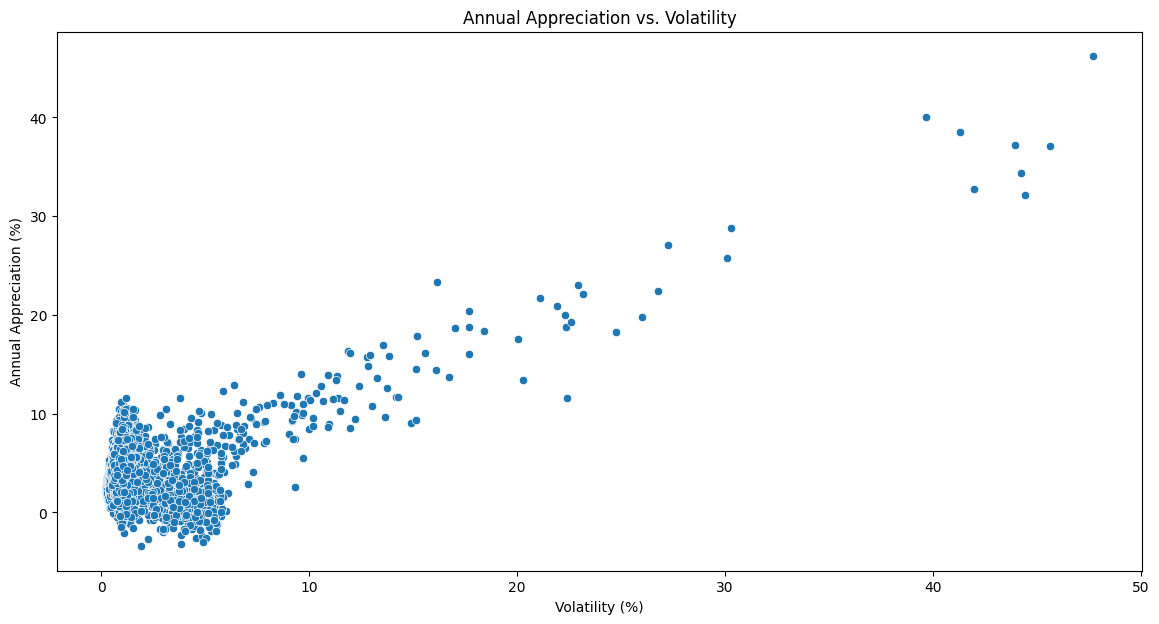

In [22]:
# Redefine price_data
price_data = df_filled_no_outliers.set_index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']).T.iloc[7:]

# Calculate annual appreciation rates
annual_appreciation_rates = price_data.pct_change(periods=12).mean() * 100

# Calculate the standard deviation of monthly price changes (volatility)
volatility = price_data.pct_change().std() * 100

# Combine into a single dataframe
metrics_df = pd.DataFrame({
    'RegionName': annual_appreciation_rates.index.get_level_values('RegionName'),
    'AnnualAppreciation': annual_appreciation_rates.values,
    'Volatility': volatility.values
})

# Bivariate plot: Annual appreciation vs. volatility
plt.figure(figsize=(14, 7))
sns.scatterplot(x='Volatility', y='AnnualAppreciation', data=metrics_df)
plt.xlabel('Volatility (%)')
plt.ylabel('Annual Appreciation (%)')
plt.title('Annual Appreciation vs. Volatility')
plt.show()


##### Price vs. Time:
There is a strong positive correlation between time and median sales prices across most zip codes.
Some zip codes exhibit stronger growth trends compared to others.
##### Price vs. Region:
Certain regions, especially major metropolitan areas, consistently show higher median prices.
Suburban and rural areas tend to have lower median prices but may show significant growth potential.
##### Price vs. SizeRank:
There is a noticeable correlation between SizeRank and median prices, with higher-ranked areas often having higher prices.
This could indicate that more populous areas, which tend to have higher SizeRanks, are more valuable.
##### Price vs. Volatility:
Zip codes with higher median prices tend to show more volatility.
This could indicate that high-value areas are subject to more significant fluctuations in market conditions.

## Reshape from Wide to Long Format

In [23]:
def melt_data(df_filled):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.
    Returns a long-form datetime dataframe
    with the datetime column names as the index and the values as the 'values' column.

    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """

    melted = pd.melt(df_filled, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'])
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [24]:
df_filled1=melt_data(df_filled)
df_filled1.head()


,value
time,
1996-04-01,117348.284996
1996-05-01,117469.999321
1996-06-01,117589.642057
1996-07-01,117706.017795
1996-08-01,117833.050329


## ARIMA Modeling

## Stationarity Check and Differencing

#### 1st Differencing

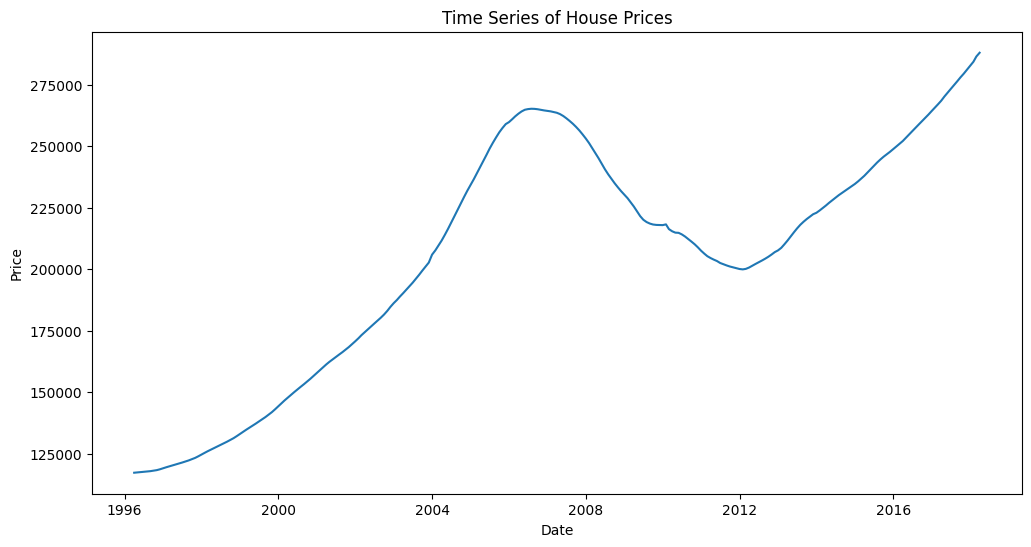

ADF Statistic: -1.923520236111722
p-value: 0.3210786192180571
ADF Statistic after differencing: -1.4088495412230682
p-value after differencing: 0.5780262607919437


In [25]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_filled1)
plt.title('Time Series of House Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Perform the Augmented Dickey-Fuller test
result = adfuller(df_filled1)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value > 0.05, the series is non-stationary and we need to difference it
if result[1] > 0.05:
    ts_diff = df_filled1.diff().dropna()
    result = adfuller(ts_diff)
    print(f'ADF Statistic after differencing: {result[0]}')
    print(f'p-value after differencing: {result[1]}')
else:
    ts_diff = df_filled1


#### Second Differencing

ADF Statistic after second differencing: -19.622168841937764
p-value after second differencing: 0.0


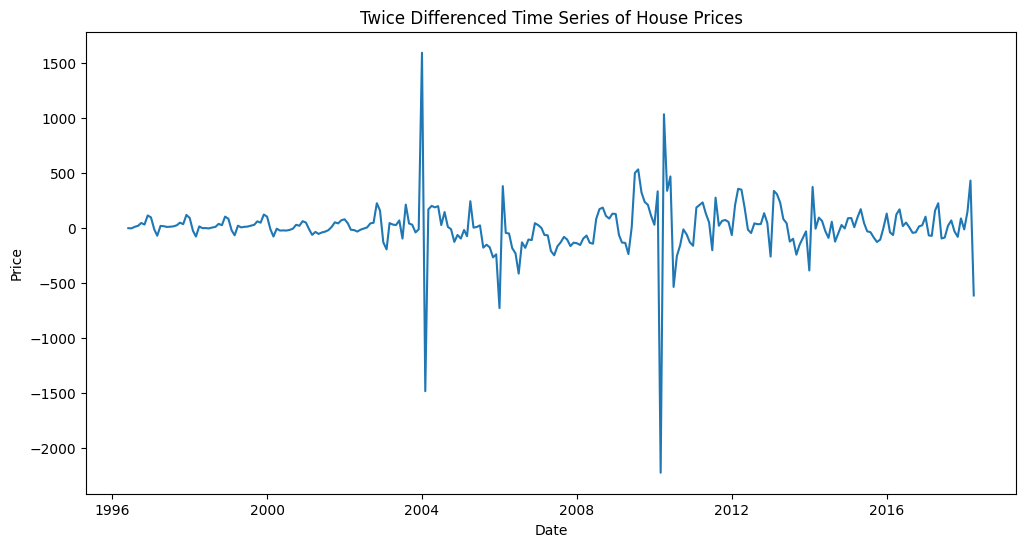

In [26]:
# Perform second differencing
ts_diff2 = df_filled1.diff().diff().dropna()

# Perform the Augmented Dickey-Fuller test on the twice differenced series
result = adfuller(ts_diff2)
print(f'ADF Statistic after second differencing: {result[0]}')
print(f'p-value after second differencing: {result[1]}')

# Plot the twice differenced series
plt.figure(figsize=(12, 6))
plt.plot(ts_diff2)
plt.title('Twice Differenced Time Series of House Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

The 2nd differencing is as close to white noise model as we get.

### Determine ARIMA Parameters (p, d, q)

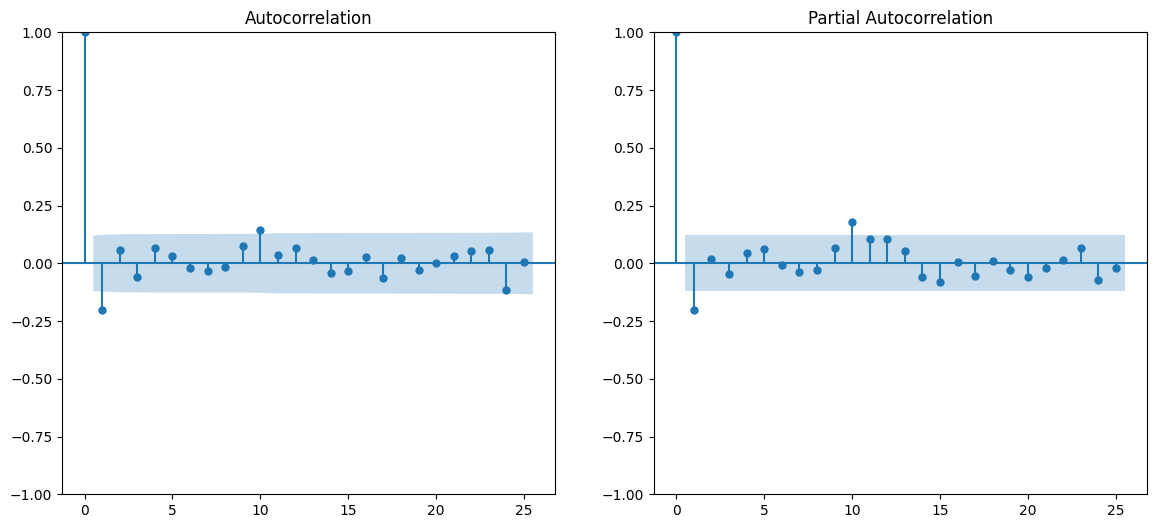

In [27]:
# Plot ACF and PACF to determine p and q
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(ts_diff2, ax=plt.gca())
plt.subplot(122)
plot_pacf(ts_diff2, ax=plt.gca())
plt.show()

### Fit the ARIMA Model

In [28]:

# Convert the index to quarterly frequency ('Q')
df_filled1.index = pd.DatetimeIndex(df_filled1.index)
df_filled1 = df_filled1.to_period('Q')

# Define the ARIMA model with the correct order and frequency
model = ARIMA(df_filled1, order=(1, 2, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  265
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1829.066
Date:                Wed, 03 Jul 2024   AIC                           3664.131
Time:                        00:55:22   BIC                           3674.848
Sample:                    06-30-1996   HQIC                          3668.438
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3828      0.615     -0.622      0.534      -1.589       0.823
ma.L1          0.3319      0.621      0.534      0.593      -0.885       1.549
sigma2      6.332e+04   1490.737     42.477      0.0

### Model Diagnostics

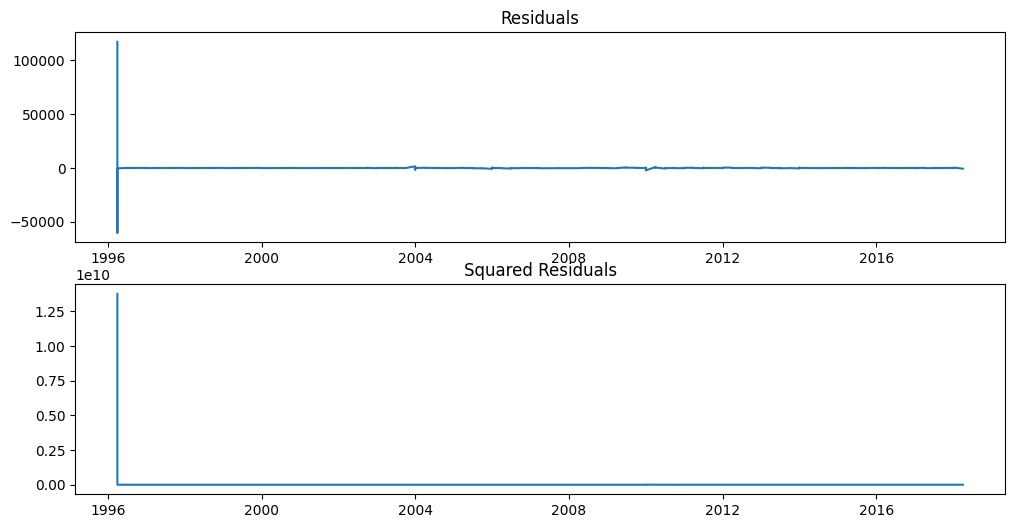

In [29]:
# Plot residuals to check for white noise
residuals = model_fit.resid

# Convert PeriodIndex to datetime
residuals.index = residuals.index.to_timestamp()

# Ensure that residuals are numeric
residuals_numeric = residuals.astype(float)

# Plotting
plt.figure(figsize=(12, 6))

# Plot the residuals
plt.subplot(211)
plt.plot(residuals.index, residuals_numeric)
plt.title('Residuals')

# Plot the squared residuals
plt.subplot(212)
plt.plot(residuals.index, residuals_numeric**2)
plt.title('Squared Residuals')

plt.show()


### Forecasting

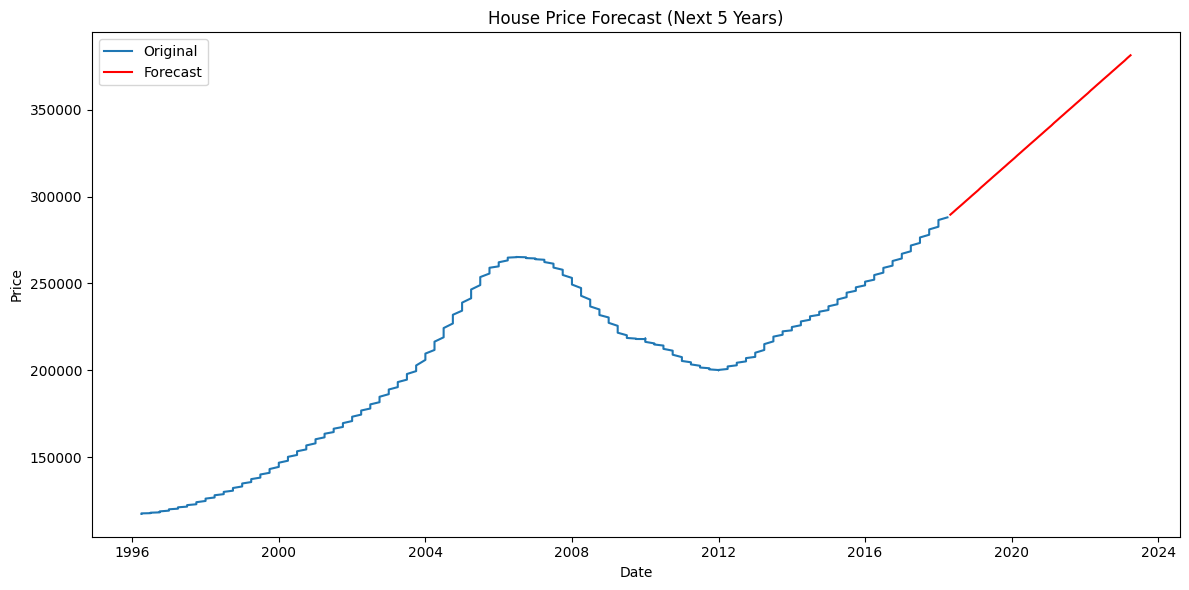

In [30]:
forecast_steps = 5 * 12  # 5 years * 12 months/year

# Generate the forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecast that starts immediately after the last historical date
# Convert last_historical_date to Timestamp before adding Timedelta
last_historical_date = df_filled1.index[-1].to_timestamp()
forecast_index = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), periods=forecast_steps, freq='M')

# Assign the new index to the forecast
forecast.index = forecast_index

# Ensure that dataframes are numeric if necessary
forecast_numeric = forecast.astype(float)
df_filled1_numeric = df_filled1.astype(float)

# Plot the forecast with adjusted figure size and layout
plt.figure(figsize=(12, 6))
# Convert the PeriodIndex to a datetime index for plotting
plt.plot(df_filled1_numeric.index.to_timestamp(), df_filled1_numeric, label='Original')
plt.plot(forecast_numeric, label='Forecast', color='red')
plt.title('House Price Forecast (Next 5 Years)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

## Interpretation

**Model Summary**
The SARIMAX model was applied to the real estate price data, and the results are summarized below:

1. Model: ARIMA(1, 2, 1)
2. Number of Observations: 265
3. Log Likelihood: -1829.066
4. AIC (Akaike Information Criterion): 3664.131
5. BIC (Bayesian Information Criterion): 3674.848
6. HQIC (Hannan-Quinn Information Criterion): 3668.438
**Parameter Estimates**
1. AR(1) Coefficient: -0.3828 (std err: 0.615, z: -0.622, p: 0.534)
2. MA(1) Coefficient: 0.3319 (std err: 0.621, z: 0.534, p: 0.593)
3. Sigma^2 (Variance of the error term): 6.332e+04 (std err: 1490.737, z: 42.477, p: 0.000)
**Diagnostic Tests**
1. Ljung-Box (L1) Test (Q): 5.89 (Prob(Q): 0.02)
2. Jarque-Bera (JB) Test: 10222.20 (Prob(JB): 0.00)
3. Heteroskedasticity (H) Test: 4.53 (Prob(H) (two-sided): 0.00)
4. Skewness: -2.10
5. Kurtosis: 33.25

**Model Fit:**
1. The model is an ARIMA(1, 2, 1), indicating that it includes one autoregressive term, two differencing steps, and one moving average term.
2. The low p-values for the Ljung-Box and Jarque-Bera tests indicate that there are some issues with residual autocorrelation and non-normality of residuals, respectively. This may suggest that the model could be improved.

**Parameter Significance:**
1. The p-values for the AR(1) and MA(1) coefficients are 0.534 and 0.593, respectively, suggesting that these parameters are not statistically significant. This could imply that the model might not be capturing the underlying patterns effectively.

**Variance:**
1. The sigma^2 value is high, indicating significant variability in the data, which is to be expected in real estate prices.

**Diagnostics:**
1. Ljung-Box Test: The p-value of 0.02 suggests that there may be some autocorrelation in the residuals, indicating that the model does not fully capture the time series structure.
2. Jarque-Bera Test: The high JB statistic with a p-value of 0.00 indicates that the residuals are not normally distributed, which might affect forecast accuracy.
3. Heteroskedasticity Test: The significant p-value suggests heteroskedasticity in the residuals, meaning that the variance of the residuals changes over time.
4. Skewness and Kurtosis: The negative skewness and high kurtosis indicate that the residuals are not normally distributed and have heavy tails.

In [31]:
# Identify date columns
date_columns = [col for col in df_filled.columns if '-' in col and col[:4].isdigit()]

# Melt the DataFrame to long format using date columns
df_melted1 = pd.melt(df_filled, id_vars=['RegionName', 'City', 'State', 'CountyName', 'Metro'],
                    value_vars=date_columns, var_name='Date', value_name='Price')

# Drop rows where 'Price' is NaN
df_melted1 = df_melted1.dropna(subset=['Price'])

# Convert 'Price' to numeric if needed
df_melted1['Price'] = pd.to_numeric(df_melted1['Price'], errors='coerce')

# Convert 'Date' to datetime format
df_melted1['Date'] = pd.to_datetime(df_melted1['Date'], format='%Y-%m')

In [32]:
# Group by 'State' and calculate the average price, filtering out states with zero average price
state_avg_prices = df_melted1.groupby('State')['Price'].mean().loc[lambda x: x != 0]

# Sort the states by average price in descending order and get the top 5
top_5_states = state_avg_prices.sort_values(ascending=False).head(5)

print(top_5_states)


State
DC    487971.048218
CA    452726.608090
HI    427385.934267
NJ    325240.623919
MA    321933.198498
Name: Price, dtype: float64


In [33]:
import pandas as pd

def melt_state_data(df_filled, state=None):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.
    Returns a long-form datetime dataframe with the datetime column names as the index
    and the values as the 'values' column, aggregated by mean price for each city.

    If 'state' is provided, it filters the dataframe for those states before melting.

    Parameters:
    - df_filled: DataFrame, the original wide-form dataset.
    - cities: list of str, optional. List of states to include. If None, includes all states.

    Returns:
    - DataFrame: A long-form DataFrame with columns ['time', 'State', 'value'].
    """

    if state:
        df_filled = df_filled[df_filled['State'].isin(state)]

    melted = pd.melt(df_filled, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'])
    melted = melted.dropna(subset=['value'])
    return melted.groupby(['time', 'State']).aggregate({'value': 'mean'}).reset_index()


In [34]:
top_5_states

State
DC    487971.048218
CA    452726.608090
HI    427385.934267
NJ    325240.623919
MA    321933.198498
Name: Price, dtype: float64

In [35]:
cities_to_plot = ['DC', 'CA', 'HI', 'NJ', 'MA']
melted_state_data = melt_state_data(df_filled, state=cities_to_plot)

In [36]:
melted_state_data.head()

,time,State,value
0,1996-04-01,CA,197564.705882
1,1996-04-01,DC,189216.666667
2,1996-04-01,HI,190045.161290
3,1996-04-01,MA,159461.151079
4,1996-04-01,NJ,175215.936255


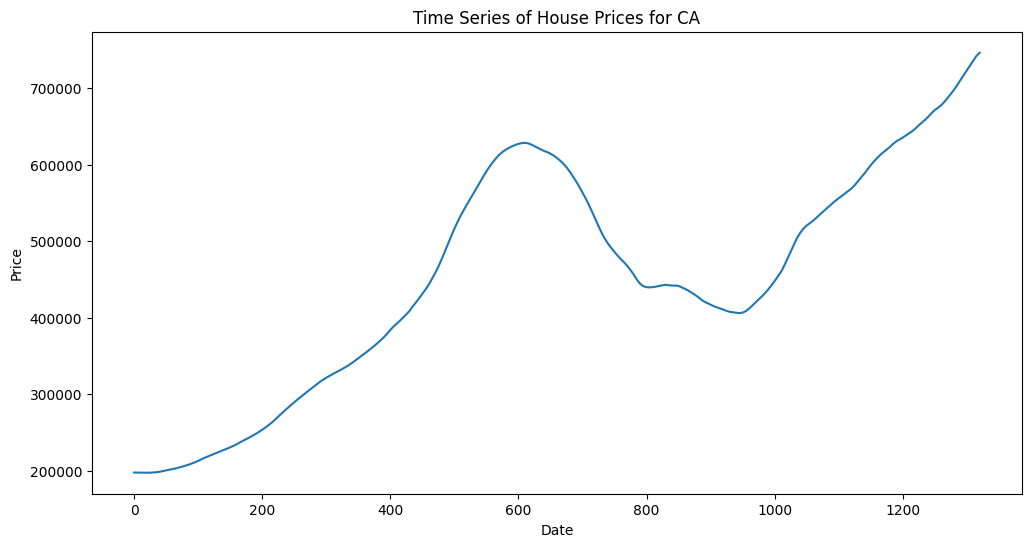

ADF Statistic for CA (Second Differenced Series): -4.356987723312447
p-value for CA (Second Differenced Series): 0.00035341359503088596


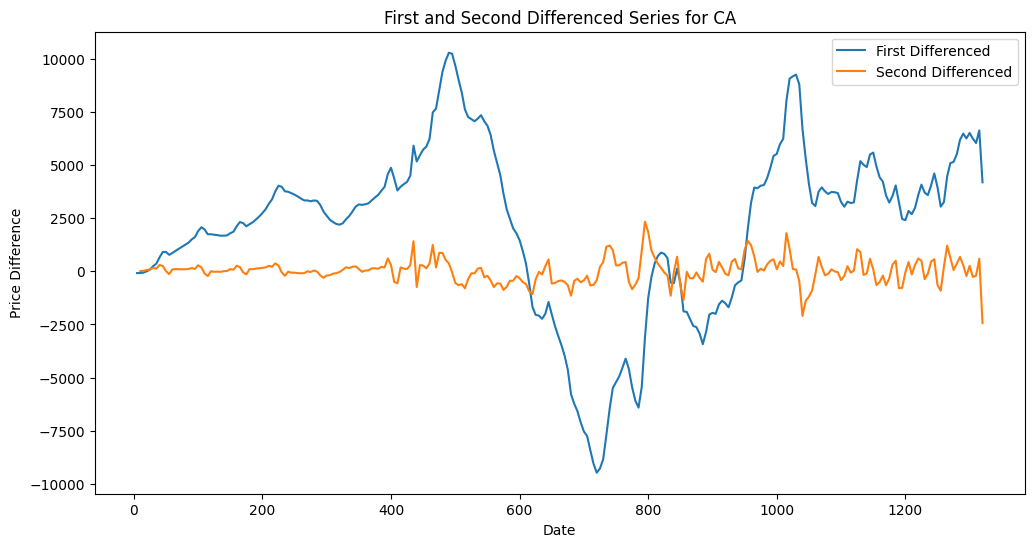

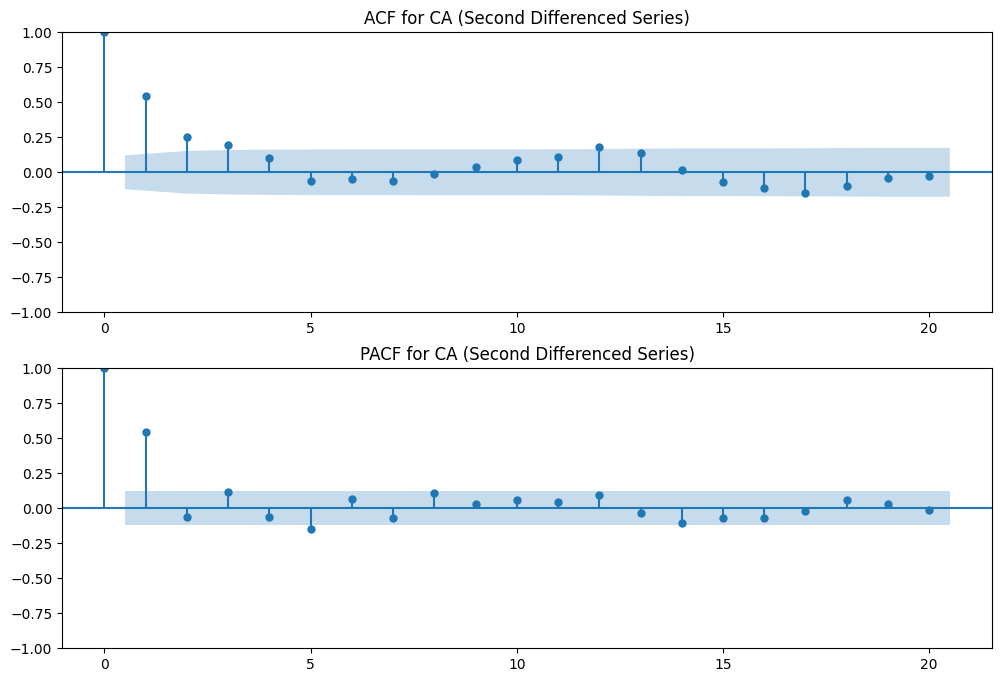

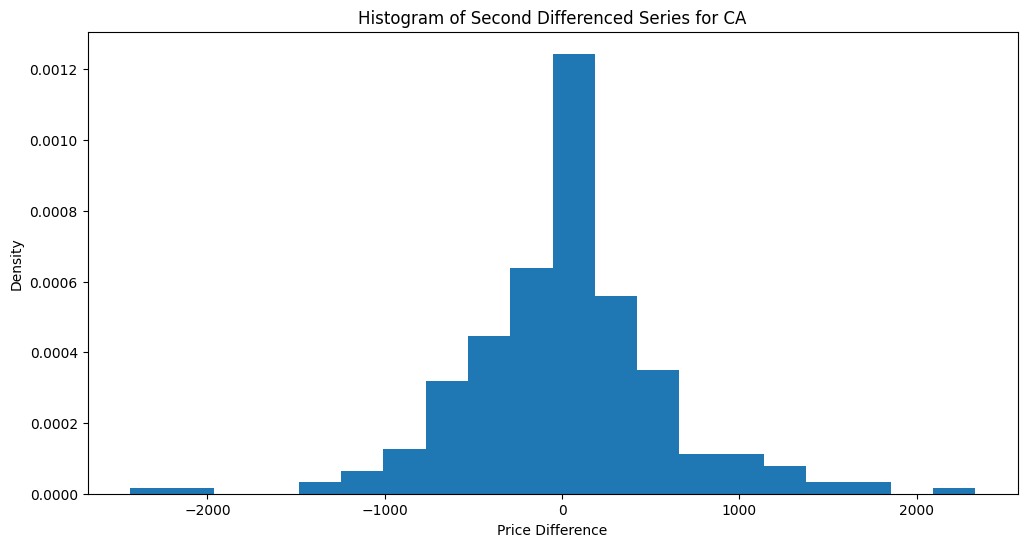

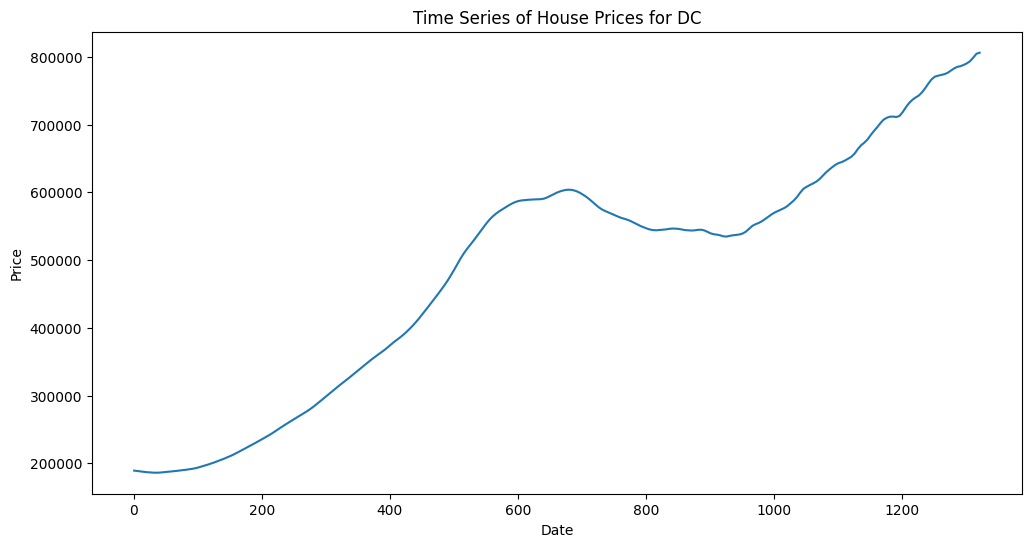

ADF Statistic for DC (Second Differenced Series): -3.9273389779423145
p-value for DC (Second Differenced Series): 0.0018426103473226565


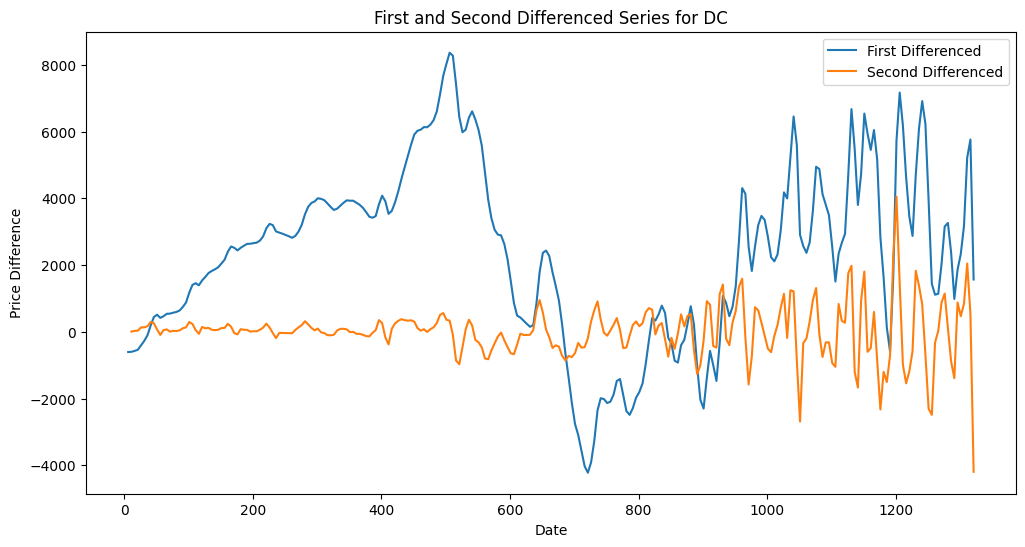

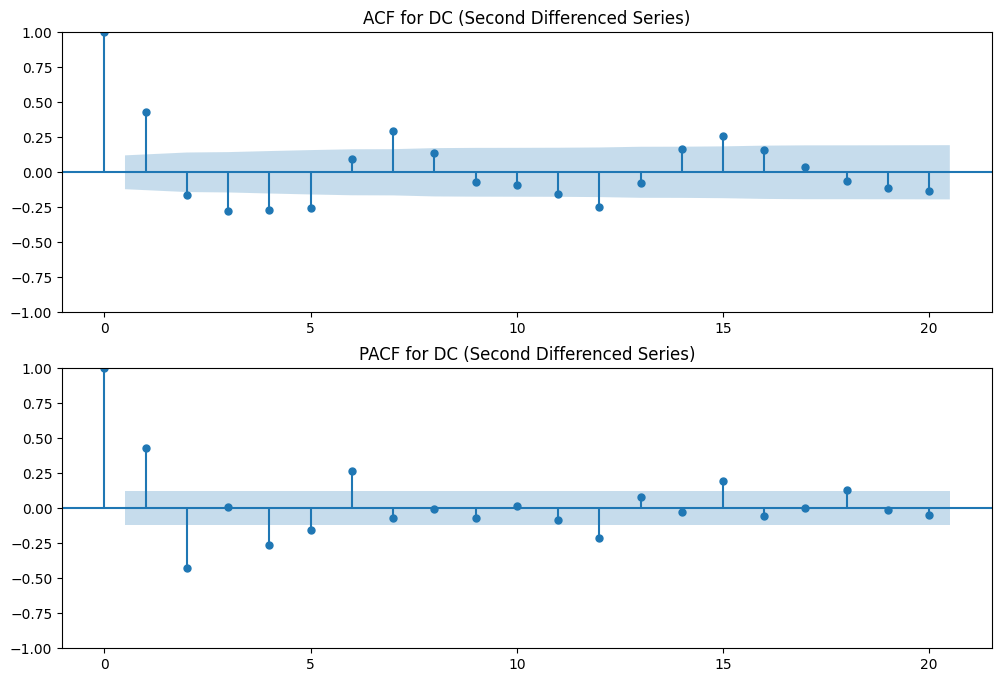

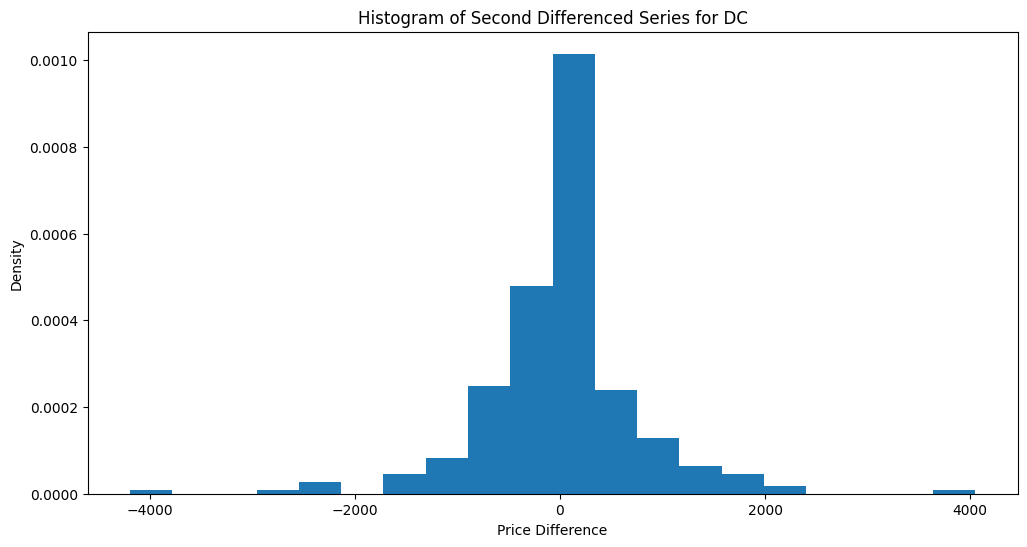

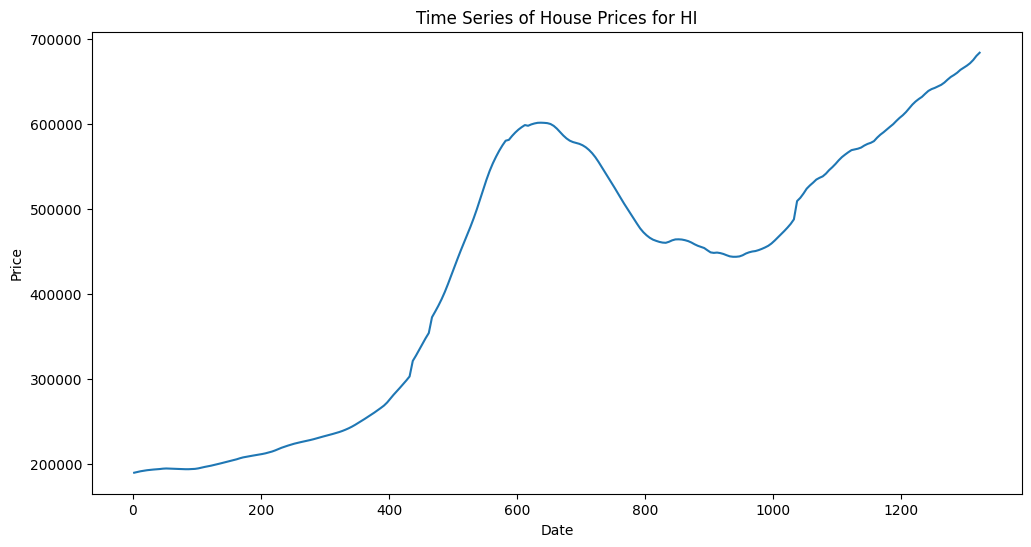

ADF Statistic for HI (Second Differenced Series): -7.573301241435548
p-value for HI (Second Differenced Series): 2.804039174744741e-11


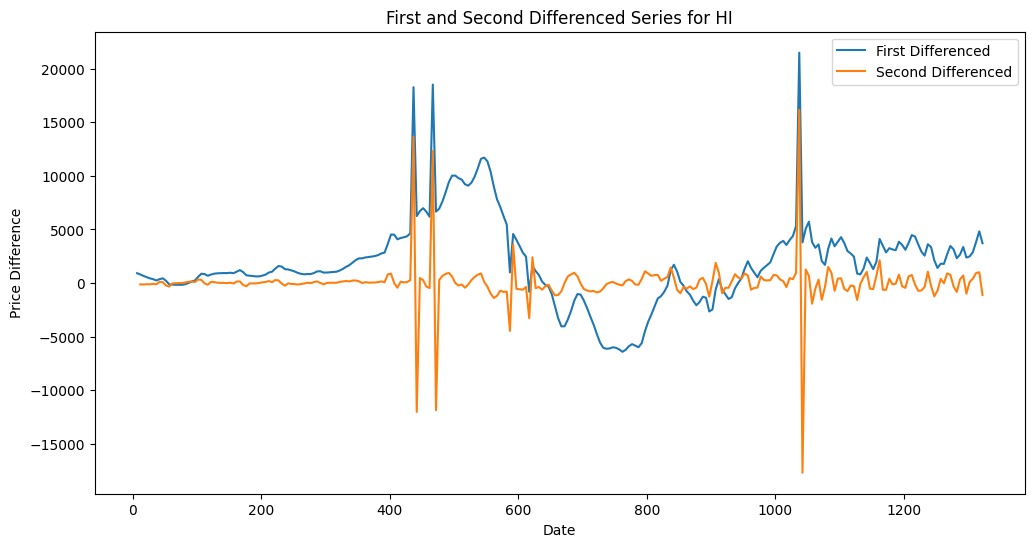

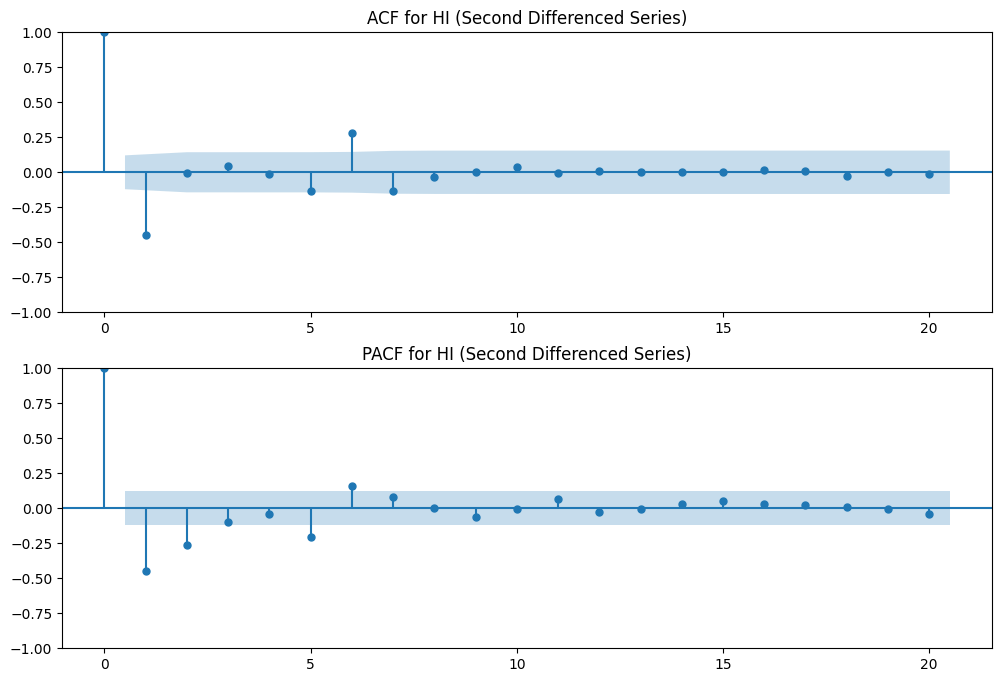

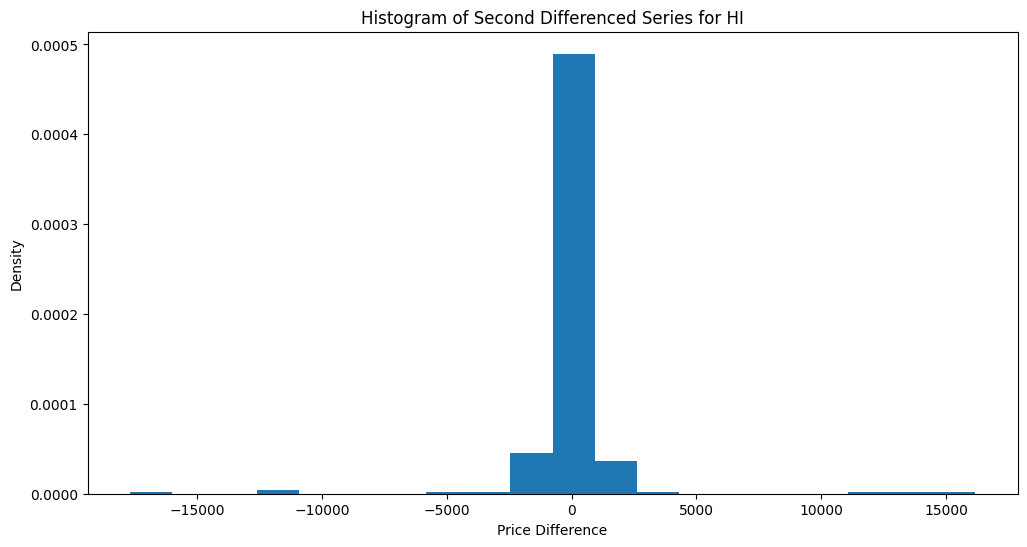

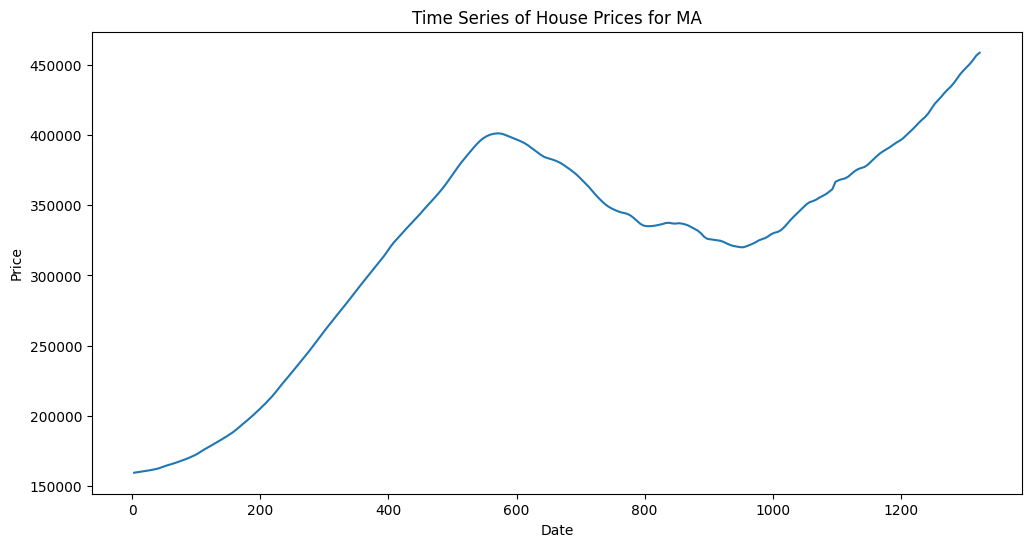

ADF Statistic for MA (Second Differenced Series): -11.82283256170377
p-value for MA (Second Differenced Series): 8.335969810337181e-22


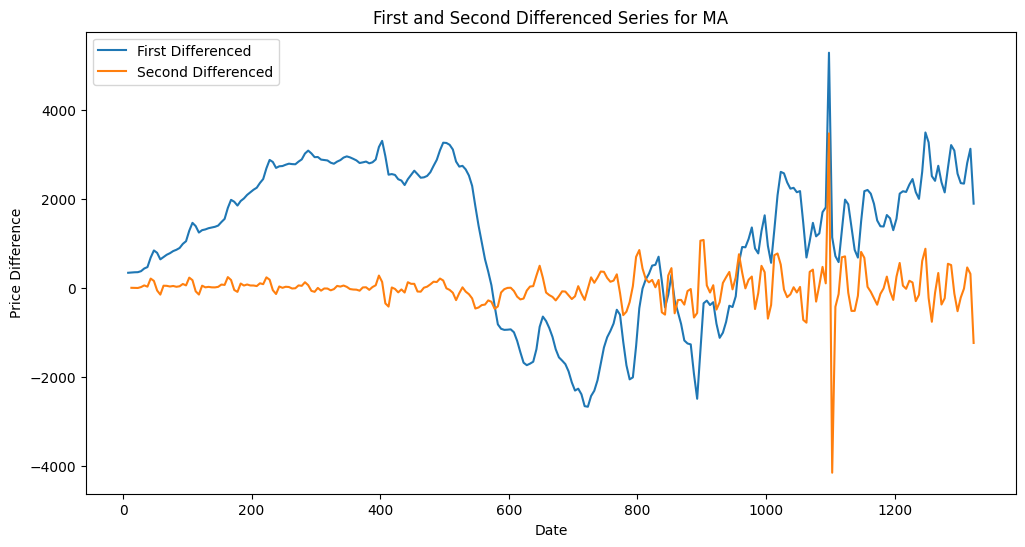

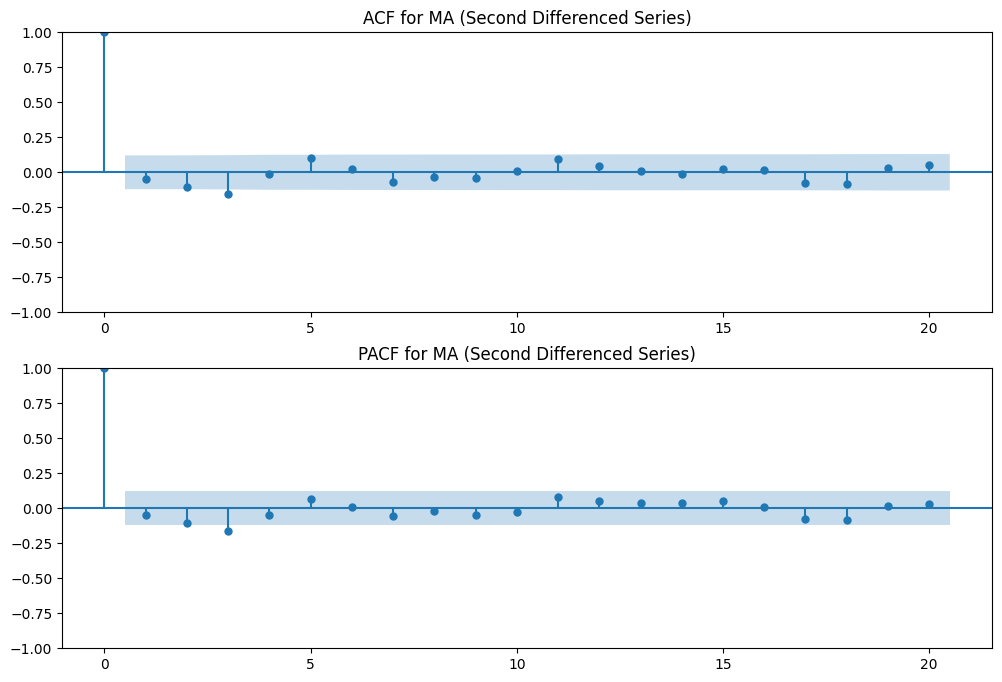

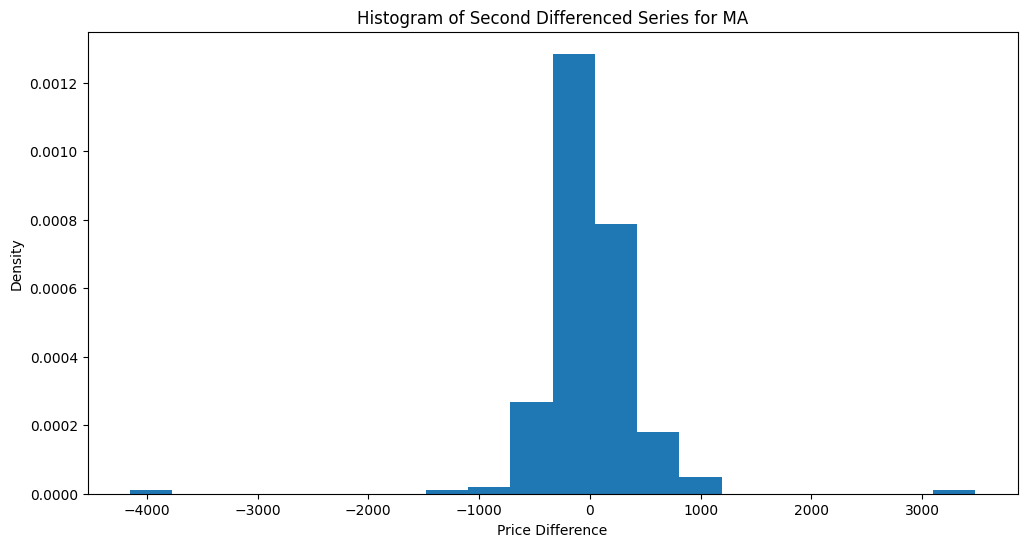

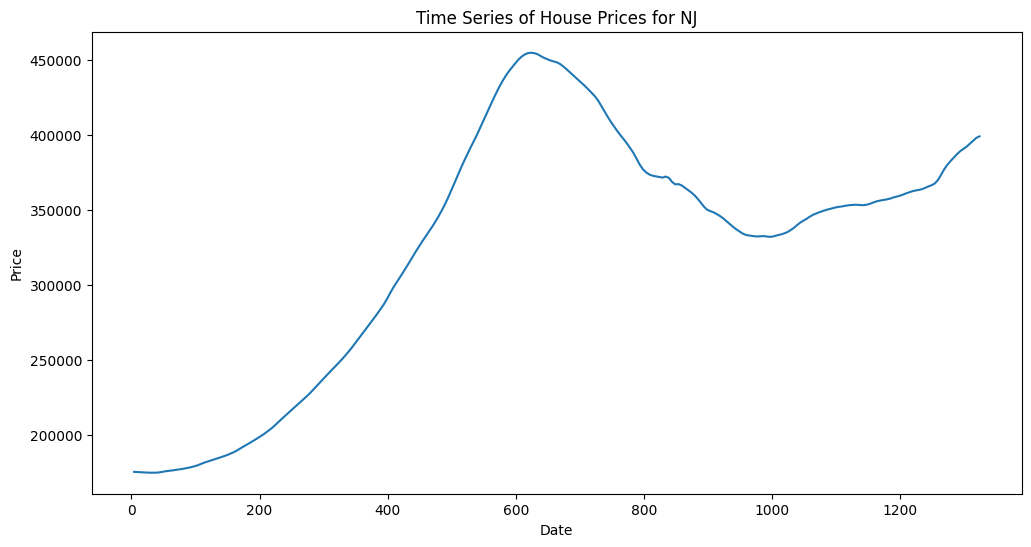

ADF Statistic for NJ (Second Differenced Series): -3.986448478831105
p-value for NJ (Second Differenced Series): 0.001483157184679738


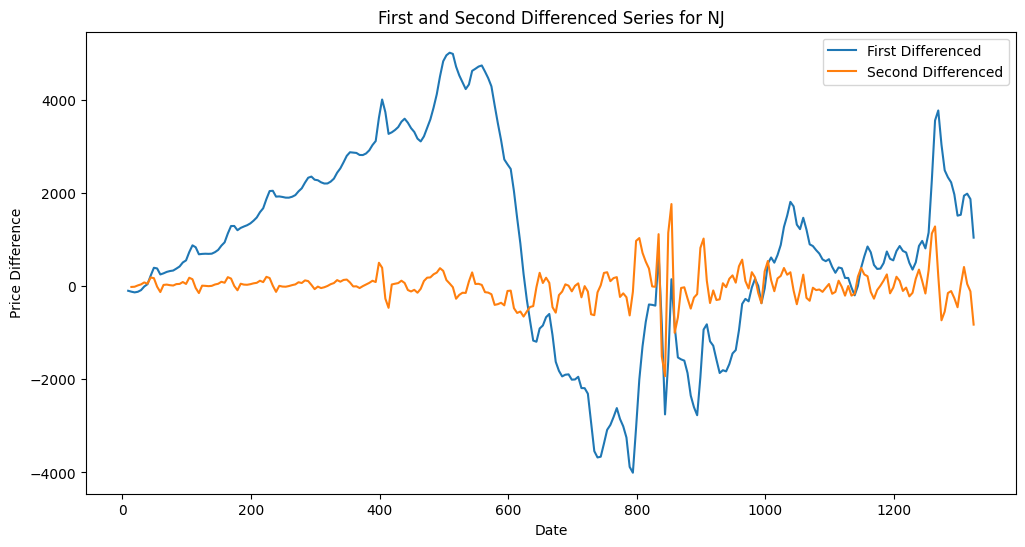

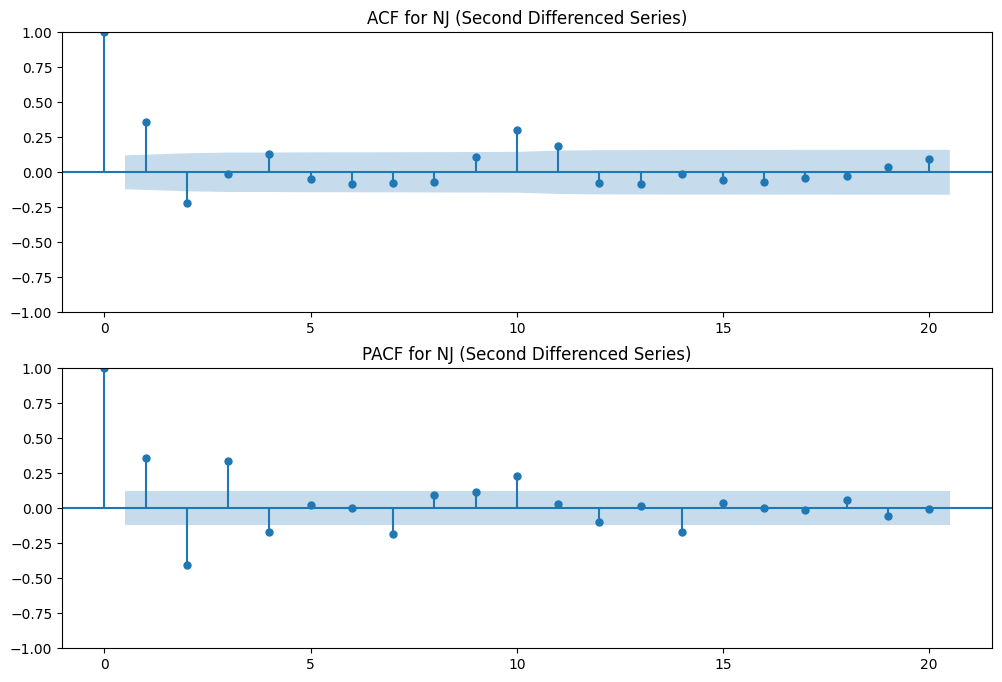

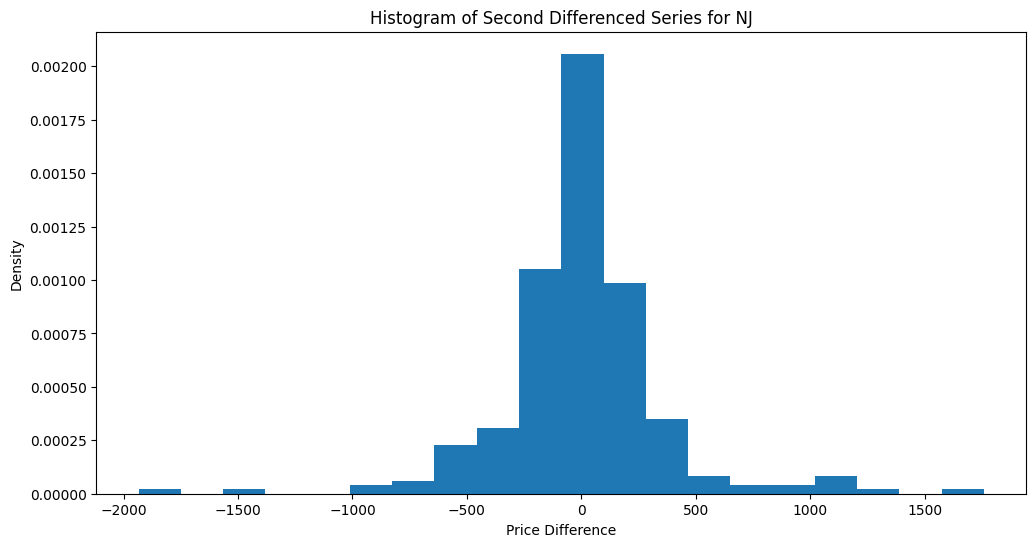

In [37]:
# Function to plot, test, and inspect differencing for states
def plot_test_differencing(melted_state_data):
    states = melted_state_data['State'].unique()

    for state in states:
        state_data = melted_state_data[melted_state_data['State'] == state]['value']

        # Plot the time series of house prices
        plt.figure(figsize=(12, 6))
        plt.plot(state_data)
        plt.title(f'Time Series of House Prices for {state}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()

        # Perform the Augmented Dickey-Fuller test for the second differencing
        ts_diff_2 = state_data.diff().diff().dropna()
        result = adfuller(ts_diff_2)
        print(f'ADF Statistic for {state} (Second Differenced Series): {result[0]}')
        print(f'p-value for {state} (Second Differenced Series): {result[1]}')

        # Plot overlapping first and second differenced series
        plt.figure(figsize=(12, 6))
        plt.plot(state_data.diff(), label='First Differenced')
        plt.plot(ts_diff_2, label='Second Differenced')
        plt.title(f'First and Second Differenced Series for {state}')
        plt.xlabel('Date')
        plt.ylabel('Price Difference')
        plt.legend()
        plt.show()

        # Plot ACF and PACF for the second differenced series
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        sm.graphics.tsa.plot_acf(ts_diff_2, lags=20, ax=ax1)
        sm.graphics.tsa.plot_pacf(ts_diff_2, lags=20, ax=ax2)
        ax1.set_title(f'ACF for {state} (Second Differenced Series)')
        ax2.set_title(f'PACF for {state} (Second Differenced Series)')
        plt.show()

        # Plot histogram of the second differenced series to check for white noise
        plt.figure(figsize=(12, 6))
        plt.hist(ts_diff_2, bins=20, density=True)
        plt.title(f'Histogram of Second Differenced Series for {state}')
        plt.xlabel('Price Difference')
        plt.ylabel('Density')
        plt.show()

# Example usage:
plot_test_differencing(melted_state_data)

In [38]:
states = melted_state_data['State'].unique()

train_test_data = {}

# Loop through each state
for state in states:
    state_data = melted_state_data[melted_state_data['State'] == state].set_index('time')['value']

    # Split into train/test sets
    train_size = int(len(state_data) * 0.8)
    train_data, test_data = state_data.iloc[:train_size], state_data.iloc[train_size:]

    train_test_data[state] = {
        'train': train_data,
        'test': test_data
    }




In [39]:
# Dictionary to store fitted models
fitted_models = {}

# ARIMA parameters (p, d, q) for each state
state_params = {
    'CA': (3, 2, 1),
    'DC': (5, 2, 2),
    'HI': (1, 2, 2),
    'MA': (1, 2, 1),
    'NJ': (2, 2, 4)
}

# Function to fit ARIMA model and summarize
def fit_arima_and_summary(train_data, order):
    model = ARIMA(train_data, order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    return fitted_model

# Loop through each state and fit ARIMA models
for state, params in state_params.items():
    train_data = train_test_data[state]['train']
    fitted_model = fit_arima_and_summary(train_data, order=params)
    fitted_models[state] = fitted_model


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  212
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1622.839
Date:                Wed, 03 Jul 2024   AIC                           3255.679
Time:                        00:55:33   BIC                           3272.414
Sample:                    04-01-1996   HQIC                          3262.444
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0302      0.023     44.116      0.000       0.984       1.076
ar.L2         -0.0114      0.011     -1.087      0.277      -0.032       0.009
ar.L3         -0.0219      0.010     -2.198      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  212
Model:                 ARIMA(5, 2, 2)   Log Likelihood               -1597.743
Date:                Wed, 03 Jul 2024   AIC                           3211.486
Time:                        00:55:34   BIC                           3238.263
Sample:                    04-01-1996   HQIC                          3222.311
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0274      4.164      0.007      0.995      -8.135       8.189
ar.L2          0.9997      2.982      0.335      0.737      -4.845       6.844
ar.L3         -0.0346      0.081     -0.425      0.6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  212
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1936.779
Date:                Wed, 03 Jul 2024   AIC                           3881.559
Time:                        00:55:35   BIC                           3894.947
Sample:                    04-01-1996   HQIC                          3886.971
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8350      0.182      4.577      0.000       0.477       1.193
ma.L1         -0.9107      0.170     -5.348      0.000      -1.245      -0.577
ma.L2          0.0065      0.021      0.309      0.7

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  212
Model:                 ARIMA(2, 2, 4)   Log Likelihood               -1533.225
Date:                Wed, 03 Jul 2024   AIC                           3080.451
Time:                        00:55:37   BIC                           3103.881
Sample:                    04-01-1996   HQIC                          3089.923
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8957      0.053    -17.011      0.000      -0.999      -0.793
ar.L2         -0.9996      0.013    -75.295      0.000      -1.026      -0.974
ma.L1          0.9240      0.057     16.268      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


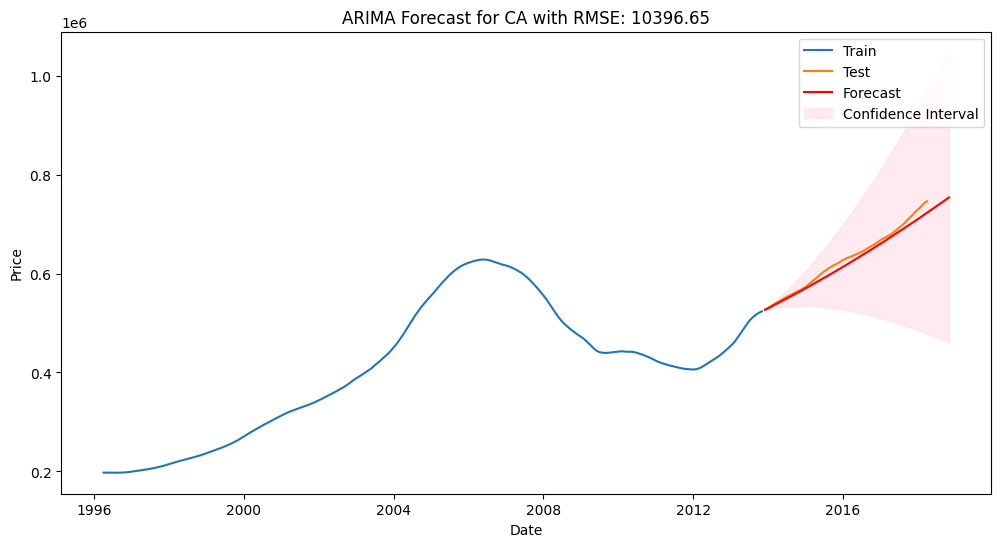

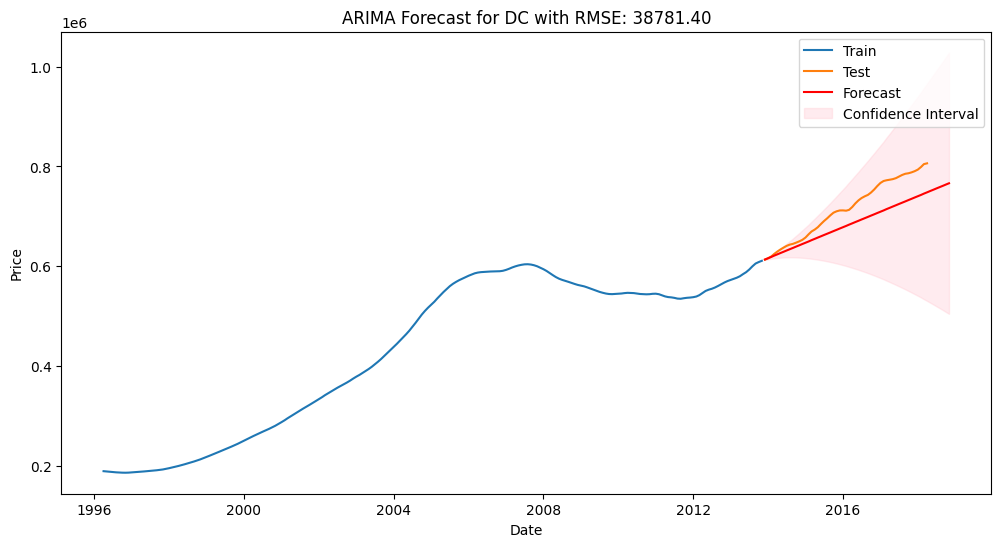

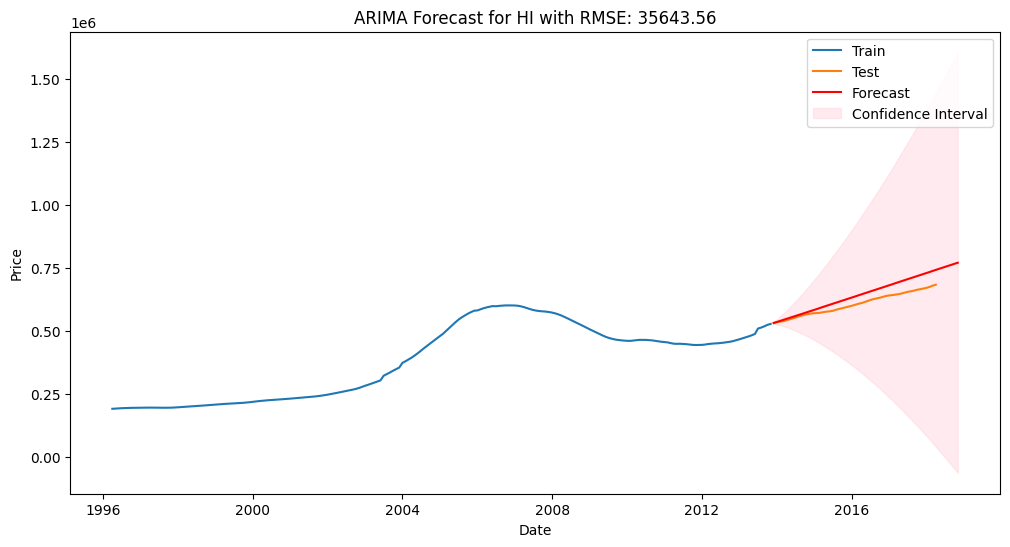

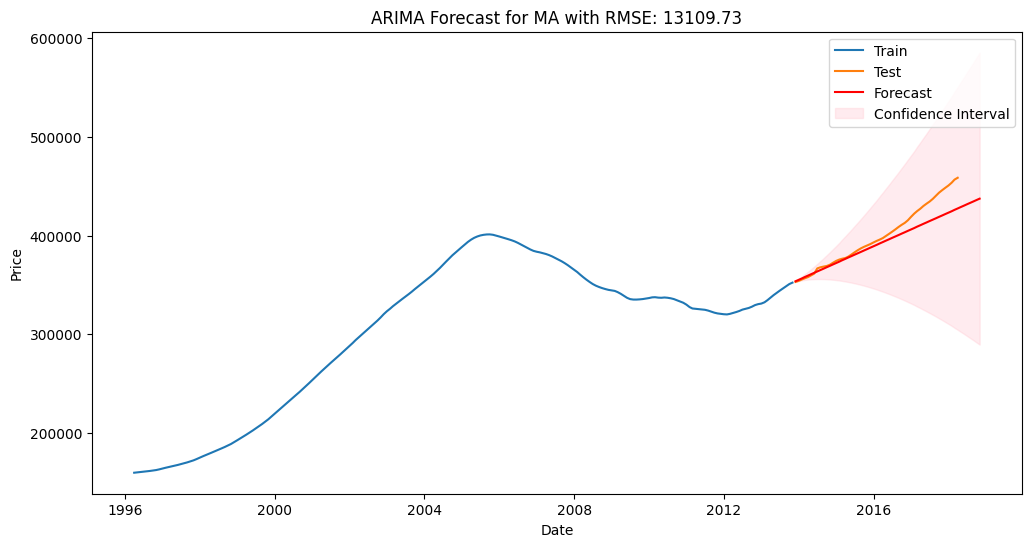

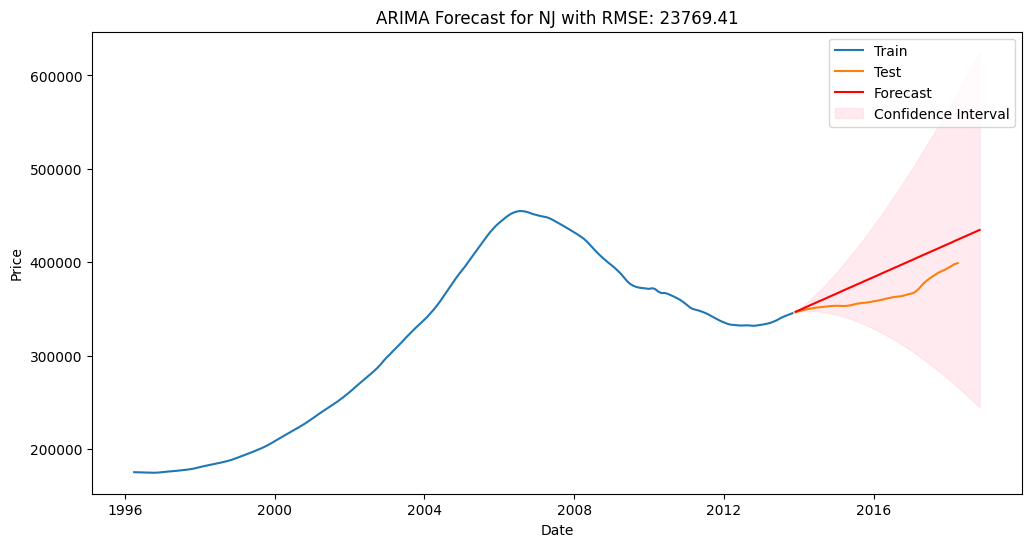

In [40]:
# Forecasting future periods
forecast_steps = 60

forecasts = {}
rmse_values = {}

for state, model in fitted_models.items():
    train_data = train_test_data[state]['train']
    test_data = train_test_data[state]['test']

    # Forecast next 60 months
    forecast = model.get_forecast(steps=forecast_steps)
    forecasts[state] = forecast

    # Compute RMSE
    forecast_values = forecast.predicted_mean
    mse = mean_squared_error(test_data, forecast_values[:len(test_data)])
    rmse = np.sqrt(mse)
    rmse_values[state] = rmse

    # Plot forecasts with RMSE
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data.values, label='Train')
    plt.plot(test_data.index, test_data.values, label='Test')
    plt.plot(forecast_values.index, forecast_values.values, color='red', label='Forecast')

    # Plot confidence interval (CI)
    forecast_ci = forecast.conf_int()
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.title(f'ARIMA Forecast for {state} with RMSE: {rmse:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


These are the top 5 states ranked by their average house price over the years with analysis done forecasting the predicted prices for 5 years.
They are:
1. California
2. Washington, D.C
3. Hawaii
4. Massachussets
5. New Jersey

## Conclusion

**Investment Potential:**

The top 5 identified states show high potential for real estate investment based on historical price trends and forecasted growth.
These states balance high profit potential with manageable risk levels, making them attractive for investment.

**Risk Assessment:**

Volatility analysis suggests that while some high-value areas are riskier, they also offer higher returns.
More stable areas provide safer investment options with moderate returns.

## Next Steps

## Recommendations

**Detailed Risk Analysis:**
Conduct a more detailed risk analysis for the top 5 states, considering factors like economic conditions, employment rates, and local developments.

**Scenario Planning:**
Develop scenario plans to understand the impact of different economic conditions on real estate prices.
Use these scenarios to prepare for potential market downturns or booms.

**Further Model Refinement:**
Refine the ARIMA model by incorporating additional variables such as interest rates, employment data, and economic indicators.
Explore other time series forecasting models to compare performance and improve accuracy.

**Diversified Investment:**
1. Invest in a diversified portfolio that includes both high-growth, high-volatility areas and stable, moderate-growth areas.
2. This strategy will balance the potential for high returns with risk management.
**Long-Term Investment:**
1. Focus on long-term investment strategies in areas with strong upward trends and stable growth.
2. Short-term investments can be considered in high-volatility areas with careful monitoring of market conditions.
**Continuous Monitoring:**
1. Continuously monitor market conditions and economic indicators that could impact the real estate market.
2. Adjust investment strategies based on new data and forecasts to optimize returns and manage risks